# Data cleaning

## Libraries and loading the data

This section is dedicated to importing necessary libraries and loading the dataset into a pandas dataframe. It utilizes pandas for data manipulation and analysis, and numpy for numerical operations. The datasets, 'investments.csv', 'rounds.csv', 'organisations.csv', 'acquisitions.csv', are loaded to perform further operations.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
investments = pd.read_csv('investments.csv')
rounds = pd.read_csv('rounds.csv')
organizations = pd.read_csv('organisations.csv')
acquisitions = pd.read_csv('acquisitions.csv')

/var/folders/lm/bl1smj695w5cs7_g73j9m6_r0000gn/T/ipykernel_19735/155591008.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  acquisitions = pd.read_csv('acquisitions.csv')


## Merge investments and rounds 

We first merge investments and rounds datasets since they have similar columns

### Initial merge

In [3]:
print('Investments dataset columns:', investments.columns)
print('Rounds dataset columns:', rounds.columns)

Investments dataset columns: Index(['company_permalink', 'company_name', 'company_category_list',
       'company_market', 'company_country_code', 'company_state_code',
       'company_region', 'company_city', 'investor_permalink', 'investor_name',
       'investor_category_list', 'investor_market', 'investor_country_code',
       'investor_state_code', 'investor_region', 'investor_city',
       'funding_round_permalink', 'funding_round_type', 'funding_round_code',
       'funded_at', 'funded_month', 'funded_quarter', 'funded_year',
       'raised_amount_usd'],
      dtype='object')
Rounds dataset columns: Index(['company_permalink', 'company_name', 'company_category_list',
       'company_market', 'company_country_code', 'company_state_code',
       'company_region', 'company_city', 'funding_round_permalink',
       'funding_round_type', 'funding_round_code', 'funded_at', 'funded_month',
       ' funded_quarter ', 'funded_year', ' raised_amount_usd ',
       'Unnamed: 16'],
      dtyp

Since the columns have different spacing, we will clean that first to ensure the same format for columns that appear in both datasets

In [4]:
# Trim spaces from column names
investments.columns = investments.columns.str.strip().str.lower().str.replace(' ', '')
rounds.columns = rounds.columns.str.strip().str.lower().str.replace(' ', '')
rounds.columns = rounds.columns.str.strip().str.lower().str.replace(' ', '')

# Remove 'Unnamed: 16' column, as it is just a blank column
rounds = rounds.iloc[:, :-1]

Since 'investments' has more columns then 'rounds', we want to indentify what are the columns that do not appear in rounds

In [5]:
print('Columns that do not appear in rounds:', set(investments.columns) - set(rounds.columns))

Columns that do not appear in rounds: {'investor_permalink', 'investor_market', 'investor_name', 'investor_category_list', 'investor_city', 'investor_state_code', 'investor_country_code', 'investor_region'}


Then, we merge the two dataframes 'investments' and 'rounds' and see what columns we have in the merged dataframes

In [6]:
merge_1 = pd.merge(rounds, 
                      investments[['company_permalink'] + list(set(investments.columns) - set(rounds.columns))], 
                      on='company_permalink', 
                      how='left')
merge_1.columns

Index(['company_permalink', 'company_name', 'company_category_list',
       'company_market', 'company_country_code', 'company_state_code',
       'company_region', 'company_city', 'funding_round_permalink',
       'funding_round_type', 'funding_round_code', 'funded_at', 'funded_month',
       'funded_quarter', 'funded_year', 'raised_amount_usd',
       'investor_permalink', 'investor_market', 'investor_name',
       'investor_category_list', 'investor_city', 'investor_state_code',
       'investor_country_code', 'investor_region'],
      dtype='object')

### Merged dataset analyze and data cleaning

Dataset information, here, you know what the length of the dataset is, column type, and the amount of missing values per columns.

This dataset has 365,344 rows

In [7]:
# Display merged dataset info
print(merge_1.info())

# Display number of missing values
print(merge_1.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365344 entries, 0 to 365343
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   company_permalink        365344 non-null  object 
 1   company_name             365343 non-null  object 
 2   company_category_list    359316 non-null  object 
 3   company_market           359309 non-null  object 
 4   company_country_code     349662 non-null  object 
 5   company_state_code       282291 non-null  object 
 6   company_region           349662 non-null  object 
 7   company_city             347075 non-null  object 
 8   funding_round_permalink  365344 non-null  object 
 9   funding_round_type       365344 non-null  object 
 10  funding_round_code       163337 non-null  object 
 11  funded_at                365344 non-null  object 
 12  funded_month             365328 non-null  object 
 13  funded_quarter           365328 non-null  object 
 14  fund

### High-level data transformation

To start off, we perform some elementary transformations to the dataset to standardize the format and enhance data quality, focusing on column names and key attributes.

In [8]:
# 'investor_permalink': Convert to lowercase
merge_1['investor_permalink'] = merge_1['investor_permalink'].str.lower()

# 'funding_round_permalink': Convert to lowercase
merge_1['funding_round_permalink'] = merge_1['funding_round_permalink'].str.lower()

# 'raised_amount_usd': Convert from string to numeric
merge_1['raised_amount_usd'] = merge_1['raised_amount_usd'].str.replace(',', '')
merge_1['raised_amount_usd'] = pd.to_numeric(merge_1['raised_amount_usd'], errors='coerce')

You can see in the dataset information that there are missing values in some columns, we then proceed fill those in to ensure data quality

In [9]:
# Fill blank values of categorical columns with none
to_fill = merge_1.columns.difference(['company_permalink', 'funding_round_permalink', 'funding_round_type',
                               'funded_at', 'funded_month', 'funded_quarter', 'funded_year', 'raised_amount_usd'])
for column in to_fill:
    merge_1[column] = merge_1[column].fillna('None')

In [10]:
# Change date type and drop rows with blank funded_at values
merge_1['funded_at'] = pd.to_datetime(merge_1['funded_at'], errors='coerce')
merge_1.dropna(subset=['funded_at'], inplace=True)

# Fill in blank value of numerical column with 0
merge_1['raised_amount_usd'].fillna(0, inplace=True)

Now there is no missing values

In [11]:
print(merge_1.isna().sum())
print(merge_1.dtypes)

company_permalink          0
company_name               0
company_category_list      0
company_market             0
company_country_code       0
company_state_code         0
company_region             0
company_city               0
funding_round_permalink    0
funding_round_type         0
funding_round_code         0
funded_at                  0
funded_month               0
funded_quarter             0
funded_year                0
raised_amount_usd          0
investor_permalink         0
investor_market            0
investor_name              0
investor_category_list     0
investor_city              0
investor_state_code        0
investor_country_code      0
investor_region            0
dtype: int64
company_permalink                  object
company_name                       object
company_category_list              object
company_market                     object
company_country_code               object
company_state_code                 object
company_region                     obje

### Simplifying date information

Here, we decided to remove the years from 'funded_quarter' and 'funded_month' to emphasize analysis on seasonal and monthly trends, eliminating year-specific influences for a generalized insight into funding patterns.



In [12]:
# funded_month': Remove year
merge_1['funded_month'] = merge_1['funded_month'].str[-2:].astype(int)

# 'funded_quarter': Remove year
merge_1['funded_quarter'] = merge_1['funded_quarter'].str[-2:].astype(int)


In [13]:
merge_1['funded_year']= merge_1['funded_year'].astype(int)

In [14]:
merge_1.dtypes

company_permalink                  object
company_name                       object
company_category_list              object
company_market                     object
company_country_code               object
company_state_code                 object
company_region                     object
company_city                       object
funding_round_permalink            object
funding_round_type                 object
funding_round_code                 object
funded_at                  datetime64[ns]
funded_month                        int64
funded_quarter                      int64
funded_year                         int64
raised_amount_usd                 float64
investor_permalink                 object
investor_market                    object
investor_name                      object
investor_category_list             object
investor_city                      object
investor_state_code                object
investor_country_code              object
investor_region                   

## Merge organizations and acquisitions

With this merge, we took a different approach where we would first clean up the datasets of 'organizations' and 'acquisitions', then perform the merge

### Organizations

In [15]:
#Checking for null values
print(organizations.isnull().sum())

#Checking variable types
print(organizations.info())

permalink               0
name                    0
homepage_url         1166
category_list         831
market                833
funding_total_usd       0
status                644
country_code            0
state_code           8415
region                  0
city                    0
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28729 entries, 0 to 28728
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   permalink          28729 non-null  object 
 1   name               28729 non-null  object 
 2   homepage_url       27563 non-null  object 
 3   category_list      27898 non-null  object 
 4   market             27896 non-null  object 
 5   funding_total_usd  28729 non-null  float64
 6   status             28085 non-null  object 
 7   country_code       28729 non-null  object 
 8   sta

In [16]:
#Dropping homepage_url column, as not necessary for further analysis 
organizations = organizations.drop('homepage_url', axis=1)

In [17]:
#Transforming date columns into pd.datetime format
organizations['founded_at'] = pd.to_datetime(organizations['founded_at'], errors='coerce')
organizations['first_funding_at'] = pd.to_datetime(organizations['first_funding_at'], errors='coerce')
organizations['last_funding_at'] = pd.to_datetime(organizations['last_funding_at'], errors='coerce')

In [18]:
#Checking variable types
organizations.dtypes

permalink                    object
name                         object
category_list                object
market                       object
funding_total_usd           float64
status                       object
country_code                 object
state_code                   object
region                       object
city                         object
funding_rounds                int64
founded_at           datetime64[ns]
first_funding_at     datetime64[ns]
last_funding_at      datetime64[ns]
dtype: object

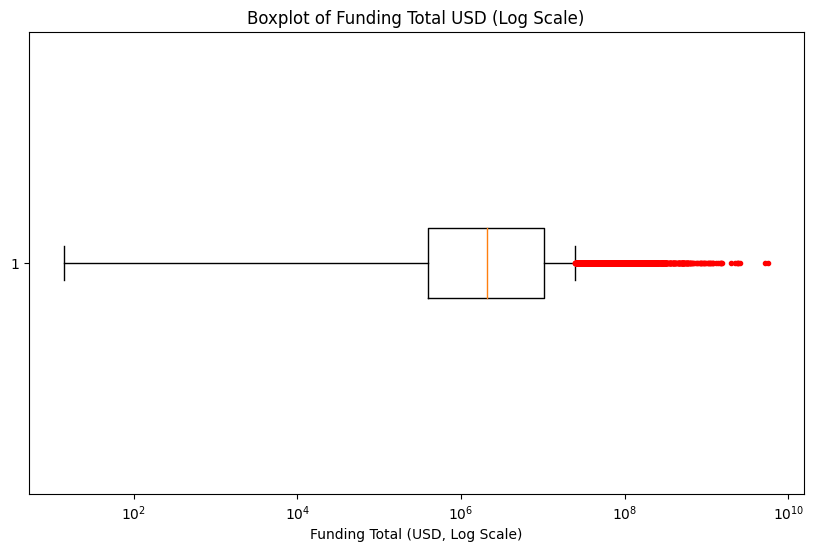

In [19]:
#Making a boxplot to visualize possible outliers 

plt.figure(figsize=(10, 6))
plt.boxplot(organizations['funding_total_usd'].dropna(), vert=False, sym="r.")  # Drop NA values for plotting, mark outliers with red dots

plt.xscale('log') #x-axis log transformed to improve visualization. 

plt.title('Boxplot of Funding Total USD (Log Scale)')
plt.xlabel('Funding Total (USD, Log Scale)')

#The boxplot indicates that there are numerous outliers, seen by the red points beyond the whiskers. 

#Here we use a common used technique to detect outliers, called Inter Quantile Range: 
#IQR, which is the difference between the 75th percentile (Q3) and the 25th percentile (Q1) of the data. 
#Outliers can then be defined as values that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR. 

Q1 = organizations['funding_total_usd'].quantile(0.25)
Q3 = organizations['funding_total_usd'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


outliers = organizations[(organizations['funding_total_usd'] < lower_bound) | (organizations['funding_total_usd'] > upper_bound)]

outliers_summary = {
    "Q1": Q1,
    "Q3": Q3,
    "IQR": IQR,
    "Lower Bound": lower_bound,
    "Upper Bound": upper_bound,
    "Number of Outliers": outliers.shape[0]
}

#Here we discard the rows for which the mentioned criteria above is met. 
organizations = organizations[(organizations['funding_total_usd'] >= lower_bound) & (organizations['funding_total_usd'] <= upper_bound)]


Here, compare to before, 3841 observations have been dropped

In [20]:
organizations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24888 entries, 0 to 28727
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   permalink          24888 non-null  object        
 1   name               24888 non-null  object        
 2   category_list      24089 non-null  object        
 3   market             24087 non-null  object        
 4   funding_total_usd  24888 non-null  float64       
 5   status             24318 non-null  object        
 6   country_code       24888 non-null  object        
 7   state_code         17212 non-null  object        
 8   region             24888 non-null  object        
 9   city               24888 non-null  object        
 10  funding_rounds     24888 non-null  int64         
 11  founded_at         24888 non-null  datetime64[ns]
 12  first_funding_at   24888 non-null  datetime64[ns]
 13  last_funding_at    24888 non-null  datetime64[ns]
dtypes: dat

### Acquisitions

In [21]:
#Checking for null values
print(acquisitions.isnull().sum())

#Checking variable types
print(acquisitions.info())

company_permalink         42170
company_name              42170
company_category_list     45453
company_market            45455
company_country_code      45457
company_state_code        47721
company_region            45456
company_city              45655
acquirer_permalink        42170
acquirer_name             42170
acquirer_category_list    43675
acquirer_market           43681
acquirer_country_code     43011
acquirer_state_code       45458
acquirer_region           43011
acquirer_city             43130
acquired_at               42170
acquired_month            42172
acquired_quarter          42172
acquired_year             42172
 price_amount             51524
price_currency_code       42174
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55240 entries, 0 to 55239
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   company_permalink       13070 non-null  object 
 1   company_na

In [22]:
acquisitions = acquisitions.dropna(subset=['company_permalink'])

duplicate_rows = acquisitions[acquisitions.duplicated(['company_permalink'], keep=False)]
print("Number of duplicated values in company_permalink column:", duplicate_rows.shape[0])
print("Duplicate rows based on company_permalink column:")
print(duplicate_rows[['company_permalink', 'company_name']])

Number of duplicated values in company_permalink column: 522
Duplicate rows based on company_permalink column:
              company_permalink      company_name
37      /organization/280-north         280 North
38      /organization/280-north         280 North
110      /organization/9threads          9Threads
111      /organization/9threads          9Threads
147     /organization/about-com         About.com
...                         ...               ...
13001  /organization/ziff-davis  Ziff Davis, Inc.
13007      /organization/zimbra            Zimbra
13008      /organization/zimbra            Zimbra
13027        /organization/zite              Zite
13028        /organization/zite              Zite

[522 rows x 2 columns]


While some of the rows are indeed identical, some of the companies were simply acquired more than once (look at the different acquired_at dates). We want to find a way how to drop actual duplicates but keep these different acquisitions

In [23]:
display(acquisitions.head(5))

display(duplicate_rows.head(5))

,company_permalink,company_name,company_category_list,company_market,company_country_code,company_state_code,company_region,company_city,acquirer_permalink,acquirer_name,...,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquired_at,acquired_month,acquired_quarter,acquired_year,price_amount,price_currency_code
0,/organization/waywire,#waywire,|Entertainment|Politics|Social Media|News|,News,USA,NY,New York City,New York,/organization/magnify,Waywire Networks,...,USA,NY,New York City,New York,2013-10-17,2013-10,2013-Q4,2013.0,NaN,USD
1,/organization/fluff-friends,(fluff)Friends,NaN,NaN,NaN,NaN,NaN,NaN,/organization/social-gaming-network,SGN (Social Gaming Network),...,USA,CA,Los Angeles,Beverly Hills,2008-09-16,2008-09,2008-Q3,2008.0,NaN,USD
2,/organization/red,(RED),|Nonprofits|,Nonprofits,USA,NY,New York City,New York,/organization/nationstar-mortgage-holdings,Nationstar Mortgage Holdings,...,USA,TX,Dallas,Lewisville,2014-05-08,2014-05,2014-Q2,2014.0,"18,000,000",USD
3,/organization/vandaele-holdings,.,NaN,NaN,NaN,NaN,NaN,NaN,/organization/hi7e,HI7E,...,USA,FL,Palm Beaches,West Palm Beach,2011-01-01,2011-01,2011-Q1,2011.0,NaN,USD
4,/organization/co-internet,.CO,|Registrars|Domains|Curated Web|,Registrars,USA,FL,Miami,Miami,/organization/neustar,Neustar,...,USA,VA,"Washington, D.C.",Sterling,2014-03-20,2014-03,2014-Q1,2014.0,"109,000,000",USD


,company_permalink,company_name,company_category_list,company_market,company_country_code,company_state_code,company_region,company_city,acquirer_permalink,acquirer_name,...,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquired_at,acquired_month,acquired_quarter,acquired_year,price_amount,price_currency_code
37,/organization/280-north,280 North,|Presentations|Software|,Software,NaN,NaN,NaN,NaN,/organization/motorola-mobility,Motorola Mobility,...,USA,IL,Chicago,Libertyville,2010-07-01,2010-07,2010-Q3,2010.0,"20,000,000",USD
38,/organization/280-north,280 North,|Presentations|Software|,Software,NaN,NaN,NaN,NaN,/organization/motorola-solutions,Motorola Solutions,...,USA,IL,Chicago,Schaumburg,2010-07-01,2010-07,2010-Q3,2010.0,"20,000,000",USD
110,/organization/9threads,9Threads,NaN,NaN,NaN,NaN,NaN,NaN,/organization/stone,Stone,...,USA,OH,Cincinnati,Independence,2012-01-01,2012-01,2012-Q1,2012.0,NaN,USD
111,/organization/9threads,9Threads,NaN,NaN,NaN,NaN,NaN,NaN,/organization/level7,Level7,...,USA,OH,Cleveland,Cleveland,2012-01-01,2012-01,2012-Q1,2012.0,NaN,USD
147,/organization/about-com,About.com,|Curated Web|,Curated Web,NaN,NaN,NaN,NaN,/organization/iac,IAC,...,USA,NY,New York City,New York,2012-08-27,2012-08,2012-Q3,2012.0,"300,000,000",USD


In [24]:
# We now compare the "acquired at" values of the company permalink duplicates
filtered_duplicates = duplicate_rows[duplicate_rows.groupby('company_permalink')['acquired_at'].transform('nunique') > 1]

# We then filter out the duplicate entries where the acquisition dates are the same for all occurrences of that company permalink
acquisitions = pd.concat([acquisitions.drop_duplicates(subset=['company_permalink'], keep=False), filtered_duplicates])

print(acquisitions.shape)

(12944, 22)


In [25]:
# Remove extra spaces from column names
acquisitions.columns = acquisitions.columns.str.strip()
acquisitions['price_amount'].head()

0              NaN
1              NaN
2      18,000,000 
3              NaN
4     109,000,000 
Name: price_amount, dtype: object

In [26]:
# Replace commas with empty string
acquisitions['price_amount'] = acquisitions['price_amount'].str.replace(',', '')
acquisitions['price_amount'] = acquisitions['price_amount'].str.replace(' ', '')
acquisitions['price_amount'] = acquisitions['price_amount'].str.replace('-', '')
acquisitions['price_amount'] = acquisitions['price_amount'].replace('', np.nan)

# Replace NaN values with zero
acquisitions.loc[acquisitions['price_amount'].isna(), 'price_amount'] = 0

# Display the first few rows of the 'price_amount' column
print(acquisitions['price_amount'].head())

0            0
1            0
2     18000000
3            0
4    109000000
Name: price_amount, dtype: object


In [27]:
# Convert to numeric
acquisitions['price_amount'] = acquisitions['price_amount'].astype(float)

# Get all unique values in the 'price_currency_code' column
unique_currency_codes = acquisitions['price_currency_code'].unique()

# Display unique currency codes
print(unique_currency_codes)

['USD' 'GBP' 'CAD' 'EUR' nan 'JPY' 'AUD' 'SEK' 'NOK' 'NZD' 'AZN' 'SAR']


In [28]:
import requests

api_key = "39538f92d2e8408a947b5a482ec96ddb"

# Function to fetch historical exchange rates from exchangeratesapi.io
def fetch_exchange_rates(base_currency, target_currency, date):
    url = f"https://openexchangerates.org/api/latest.json?app_id={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data['rates'][target_currency]
    else:
        print(f"Failed to fetch exchange rate data for {date}: {response.status_code}")
        return None

# Apply currency conversion and update currency code to USD
mask = ~acquisitions['price_currency_code'].isna()  # Mask for non-null currency codes
for idx, row in acquisitions[mask].iterrows():
    acquisition_date = row['acquired_at']
    currency_code = row['price_currency_code']
    if currency_code != 'USD':
        conversion_rate = fetch_exchange_rates(currency_code, 'USD', acquisition_date)
        if conversion_rate is not None:
            acquisitions.loc[idx, 'price_amount'] *= conversion_rate
            acquisitions.loc[idx, 'price_currency_code'] = 'USD'

Failed to fetch exchange rate data for 2010-08-12: 429
Failed to fetch exchange rate data for 2014-09-24: 429
Failed to fetch exchange rate data for 2007-04-01: 429
Failed to fetch exchange rate data for 2010-06-30: 429
Failed to fetch exchange rate data for 2014-03-13: 429
Failed to fetch exchange rate data for 2014-03-04: 429
Failed to fetch exchange rate data for 2011-06-01: 429
Failed to fetch exchange rate data for 2014-11-25: 429
Failed to fetch exchange rate data for 2013-04-28: 429
Failed to fetch exchange rate data for 2013-09-04: 429
Failed to fetch exchange rate data for 2011-10-24: 429
Failed to fetch exchange rate data for 2014-08-11: 429
Failed to fetch exchange rate data for 2010-05-07: 429
Failed to fetch exchange rate data for 2008-07-16: 429
Failed to fetch exchange rate data for 2014-04-16: 429
Failed to fetch exchange rate data for 2014-08-04: 429
Failed to fetch exchange rate data for 2008-01-03: 429
Failed to fetch exchange rate data for 2014-07-11: 429
Failed to 

Failed to fetch exchange rate data for 1987-06-16: 429
Failed to fetch exchange rate data for 2012-06-01: 429
Failed to fetch exchange rate data for 2010-06-21: 429
Failed to fetch exchange rate data for 1987-06-16: 429
Failed to fetch exchange rate data for 2011-07-19: 429
Failed to fetch exchange rate data for 2003-02-18: 429
Failed to fetch exchange rate data for 2014-06-06: 429
Failed to fetch exchange rate data for 2010-03-12: 429
Failed to fetch exchange rate data for 2014-02-27: 429
Failed to fetch exchange rate data for 2014-09-08: 429
Failed to fetch exchange rate data for 2013-12-19: 429
Failed to fetch exchange rate data for 2013-09-23: 429
Failed to fetch exchange rate data for 2011-07-28: 429
Failed to fetch exchange rate data for 2014-02-04: 429
Failed to fetch exchange rate data for 2012-09-14: 429
Failed to fetch exchange rate data for 2014-07-08: 429
Failed to fetch exchange rate data for 2014-02-05: 429
Failed to fetch exchange rate data for 2014-07-25: 429
Failed to 

In [29]:
# Display DataFrame after conversion
display(acquisitions)

,company_permalink,company_name,company_category_list,company_market,company_country_code,company_state_code,company_region,company_city,acquirer_permalink,acquirer_name,...,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquired_at,acquired_month,acquired_quarter,acquired_year,price_amount,price_currency_code
0,/organization/waywire,#waywire,|Entertainment|Politics|Social Media|News|,News,USA,NY,New York City,New York,/organization/magnify,Waywire Networks,...,USA,NY,New York City,New York,2013-10-17,2013-10,2013-Q4,2013.0,0.0,USD
1,/organization/fluff-friends,(fluff)Friends,NaN,NaN,NaN,NaN,NaN,NaN,/organization/social-gaming-network,SGN (Social Gaming Network),...,USA,CA,Los Angeles,Beverly Hills,2008-09-16,2008-09,2008-Q3,2008.0,0.0,USD
2,/organization/red,(RED),|Nonprofits|,Nonprofits,USA,NY,New York City,New York,/organization/nationstar-mortgage-holdings,Nationstar Mortgage Holdings,...,USA,TX,Dallas,Lewisville,2014-05-08,2014-05,2014-Q2,2014.0,18000000.0,USD
3,/organization/vandaele-holdings,.,NaN,NaN,NaN,NaN,NaN,NaN,/organization/hi7e,HI7E,...,USA,FL,Palm Beaches,West Palm Beach,2011-01-01,2011-01,2011-Q1,2011.0,0.0,USD
4,/organization/co-internet,.CO,|Registrars|Domains|Curated Web|,Registrars,USA,FL,Miami,Miami,/organization/neustar,Neustar,...,USA,VA,"Washington, D.C.",Sterling,2014-03-20,2014-03,2014-Q1,2014.0,109000000.0,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13001,/organization/ziff-davis,"Ziff Davis, Inc.",|Games|,Games,USA,NY,New York City,New York,/organization/softbank,SoftBank,...,JPN,NaN,Tokyo,Tokyo,1996-02-01,1996-02,1996-Q1,1996.0,0.0,USD
13007,/organization/zimbra,Zimbra,|Collaboration|Productivity Software|Web Devel...,Productivity Software,USA,CA,SF Bay Area,Palo Alto,/organization/telligentsystems,Telligent Systems,...,USA,TX,Dallas,Dallas,2013-07-15,2013-07,2013-Q3,2013.0,0.0,USD
13008,/organization/zimbra,Zimbra,|Collaboration|Productivity Software|Web Devel...,Productivity Software,USA,CA,SF Bay Area,Palo Alto,/organization/yahoo,Yahoo!,...,USA,CA,SF Bay Area,Sunnyvale,2007-09-01,2007-09,2007-Q3,2007.0,350000000.0,USD
13027,/organization/zite,Zite,|Publishing|,Publishing,USA,CA,SF Bay Area,San Francisco,/organization/flipboard,Flipboard,...,USA,CA,SF Bay Area,Palo Alto,2014-03-05,2014-03,2014-Q1,2014.0,60000000.0,USD


In [30]:
# Get all unique values in the 'price_currency_code' column
unique_currency_codes = acquisitions['price_currency_code'].unique()
print(unique_currency_codes)

# Create a new column price_currency_code_new with values 'USD'
acquisitions['price_currency_code_new'] = 'USD'

['USD' 'GBP' 'CAD' 'EUR' nan 'JPY' 'AUD' 'SEK' 'NOK' 'NZD' 'AZN' 'SAR']


In [31]:
# Convert date columns to datetime format with errors='coerce'
acquisitions['acquired_at'] = pd.to_datetime(acquisitions['acquired_at'], errors='coerce')

# Identify rows with NaT values in 'acquired_at' column
na_rows = acquisitions[acquisitions['acquired_at'].isna()]

# Remove rows with NaT values in 'acquired_at' column
acquisitions.dropna(subset=['acquired_at'], inplace=True)

In [32]:
#Checking for null values
print(acquisitions.isnull().sum())

#Checking variable types
print(acquisitions.info())

company_permalink             0
company_name                  0
company_category_list      3267
company_market             3269
company_country_code       3269
company_state_code         5508
company_region             3268
company_city               3465
acquirer_permalink            0
acquirer_name                 0
acquirer_category_list     1490
acquirer_market            1496
acquirer_country_code       832
acquirer_state_code        3257
acquirer_region             832
acquirer_city               951
acquired_at                   0
acquired_month                0
acquired_quarter              0
acquired_year                 0
price_amount                  0
price_currency_code           4
price_currency_code_new       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12942 entries, 0 to 13028
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   company_permali

In [33]:
# Remove the first and last occurence of "|" in the company_category_list
acquisitions['company_category_list'] = acquisitions['company_category_list'].str.strip('|').str.strip()
print(acquisitions['company_category_list'].head)

# Do the same for acquirer category list to keep the same format: 
acquisitions['acquirer_category_list'] = acquisitions['acquirer_category_list'].str.strip('|').str.strip()
print(acquisitions['acquirer_category_list'].head)

<bound method NDFrame.head of 0                 Entertainment|Politics|Social Media|News
1                                                      NaN
2                                               Nonprofits
3                                                      NaN
4                           Registrars|Domains|Curated Web
                               ...                        
13001                                                Games
13007    Collaboration|Productivity Software|Web Develo...
13008    Collaboration|Productivity Software|Web Develo...
13027                                           Publishing
13028                                           Publishing
Name: company_category_list, Length: 12942, dtype: object>
<bound method NDFrame.head of 0                                        Curated Web|Video
1                                                    Games
2                                                  Finance
3                                                      

### Merge 'organizations' and 'acquisitions'

In [34]:
merge_2 = pd.merge(organizations, acquisitions, left_on='permalink', right_on='company_permalink', how='left')

display(merge_2.head())

,permalink,name,category_list,market,funding_total_usd,status,country_code,state_code,region,city,...,acquirer_state_code,acquirer_region,acquirer_city,acquired_at,acquired_month,acquired_quarter,acquired_year,price_amount,price_currency_code,price_currency_code_new
0,/organization/waywire,#waywire,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,New York,...,NY,New York City,New York,2013-10-17,2013-10,2013-Q4,2013.0,0.0,USD,USD
1,/organization/rock-your-paper,'Rock' Your Paper,|Publishing|Education|,Publishing,40000.0,operating,EST,NaN,Tallinn,Tallinn,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,/organization/in-touch-network,(In)Touch Network,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,1500000.0,operating,GBR,NaN,London,London,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,/organization/r-ranch-and-mine,-R- Ranch and Mine,|Tourism|Entertainment|Games|,Tourism,60000.0,operating,USA,TX,Dallas,Fort Worth,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,/organization/club-domains,.Club Domains,|Software|,Software,7000000.0,NaN,USA,FL,Ft. Lauderdale,Oakland Park,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


Since acquisitions contains similar information compared to organizations, we drop the similar columns

In [35]:
to_drop = ['company_permalink', 'company_name', 'company_category_list', 'company_market', 'company_country_code',
'company_state_code', 'company_region', 'company_city']
merge_2 = merge_2.drop(to_drop, axis=1)

In [36]:
to_fill_category = ['acquirer_permalink', 'acquirer_name',
       'acquirer_category_list', 'acquirer_market', 'acquirer_country_code',
       'acquirer_state_code', 'acquirer_region', 'acquirer_city',
       'acquired_at', 'acquired_month', 'acquired_quarter', 'acquired_year', 
                    'price_currency_code', 'price_currency_code_new']

for column in to_fill_category:
    merge_2[column] = merge_2[column].fillna('None')

merge_2['price_amount'].fillna(0, inplace=True)

# Import organizations and acquisition merger

In [37]:
print('investments + rounds length', merge_1.shape)
print('organization + acquisitions length', merge_2.shape)

print(len(merge_1) - len(merge_2))

investments + rounds length (365328, 24)
organization + acquisitions length (24948, 29)
340380


### The below block of code determines which side to merge the two datasets on

In [38]:
# common_ids = set(merge_2['permalink']).intersection(set(merge_1['company_permalink']))
common_ids = set(merge_1['company_permalink']).intersection(set(merge_2['permalink']))

check_investments = merge_1[~merge_1['company_permalink'].isin(common_ids)]
check_org = merge_2[~merge_2['permalink'].isin(common_ids)] #permalink in rounds that does not exist in common id set == not in investments df

print(check_org.shape)
print(check_investments.shape)

(8, 29)
(216758, 24)


In [39]:
df_merge = pd.merge(merge_2, merge_1, left_on='permalink', right_on='company_permalink', how='right')

In [40]:
df_merge.shape

(365858, 53)

In [41]:
df_merge.isna().sum() 
#missing values of merged_org_acq columns is precisely the number of permalinks that does not exist in the common_ids set

permalink                  216758
name                       216758
category_list              218066
market                     218068
funding_total_usd          216758
status                     219348
country_code               216758
state_code                 249842
region                     216758
city                       216758
funding_rounds             216758
founded_at                 216758
first_funding_at           216758
last_funding_at            216758
acquirer_permalink         216758
acquirer_name              216758
acquirer_category_list     216758
acquirer_market            216758
acquirer_country_code      216758
acquirer_state_code        216758
acquirer_region            216758
acquirer_city              216758
acquired_at                216758
acquired_month             216758
acquired_quarter           216758
acquired_year              216758
price_amount               216758
price_currency_code        216758
price_currency_code_new    216758
company_permal

We want to drop columns in the comp_cols list, since its essentially the same as org_cols list

To drop comp_cols, first, we would have to fill in missing values of org_cols list

In [42]:
comp_cols = ['company_permalink', 'company_name', 'company_category_list', 'company_market', 'company_country_code',
'company_state_code', 'company_region', 'company_city']
org_cols = ['permalink', 'name', 'category_list', 'market', 'country_code',
'state_code', 'region', 'city']

for org in org_cols:
    for comp in comp_cols:
        df_merge[org].fillna(df_merge[comp], inplace=True)

In [43]:
df_merge = df_merge.drop(comp_cols, axis=1)

In [44]:
df_merge.shape

(365858, 45)

Now that columns in org_cols have no blank values since it's been filled already. The other blank values we will keep it as is, since there's no replacement to be made, filling it in just essentially creating duplicates, which we dont want (for example: funding_total)

In [45]:
df_merge.isna().sum()

permalink                       0
name                            0
category_list                   0
market                          0
funding_total_usd          216758
status                     219348
country_code                    0
state_code                      0
region                          0
city                            0
funding_rounds             216758
founded_at                 216758
first_funding_at           216758
last_funding_at            216758
acquirer_permalink         216758
acquirer_name              216758
acquirer_category_list     216758
acquirer_market            216758
acquirer_country_code      216758
acquirer_state_code        216758
acquirer_region            216758
acquirer_city              216758
acquired_at                216758
acquired_month             216758
acquired_quarter           216758
acquired_year              216758
price_amount               216758
price_currency_code        216758
price_currency_code_new    216758
funding_round_

In [46]:
df_merge.head(10)

,permalink,name,category_list,market,funding_total_usd,status,country_code,state_code,region,city,...,funded_year,raised_amount_usd,investor_permalink,investor_market,investor_name,investor_category_list,investor_city,investor_state_code,investor_country_code,investor_region
0,/organization/waywire,#waywire,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,New York,...,2012,1750000.0,/organization/afsquare,Finance,AFSquare,|Finance|,Culver City,CA,USA,Los Angeles
1,/organization/waywire,#waywire,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,New York,...,2012,1750000.0,/organization/first-round-capital,None,First Round,None,San Francisco,CA,USA,SF Bay Area
2,/organization/waywire,#waywire,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,New York,...,2012,1750000.0,/organization/innovation-endeavors,Finance,Innovation Endeavors,|Venture Capital|Finance|,Palo Alto,CA,USA,SF Bay Area
3,/organization/waywire,#waywire,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,New York,...,2012,1750000.0,/person/jeff-weiner,None,Jeff Weiner,None,None,None,None,None
4,/organization/waywire,#waywire,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,New York,...,2012,1750000.0,/person/oprah-winfrey,None,Oprah Winfrey,None,None,None,None,None
5,/organization/waywire,#waywire,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,New York,...,2012,1750000.0,/person/troy-carter,None,Troy Carter,None,None,None,None,None
6,/organization/tv-communications,/organization/tv-communications,/organization/tv-communications,/organization/tv-communications,NaN,NaN,/organization/tv-communications,/organization/tv-communications,/organization/tv-communications,/organization/tv-communications,...,2010,3000000.0,None,None,None,None,None,None,None,None
7,/organization/tv-communications,/organization/tv-communications,/organization/tv-communications,/organization/tv-communications,NaN,NaN,/organization/tv-communications,/organization/tv-communications,/organization/tv-communications,/organization/tv-communications,...,2010,1000000.0,None,None,None,None,None,None,None,None
8,/organization/rock-your-paper,'Rock' Your Paper,|Publishing|Education|,Publishing,40000.0,operating,EST,/organization/rock-your-paper,Tallinn,Tallinn,...,2012,40000.0,/organization/start-up-chile,None,Start-Up Chile,None,Santiago,None,CHL,Santiago
9,/organization/in-touch-network,(In)Touch Network,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,1500000.0,operating,GBR,/organization/in-touch-network,London,London,...,2011,1500000.0,None,None,None,None,None,None,None,None


## Final data engineering

## Data preperation

Firstly, we drop all rows that are missing values for the target variable funding_total_usd

In [47]:
df_merge.dropna(subset=['funding_total_usd'], inplace=True)

Then, we looked at the different country codes that were mentioned in the whole dataset. The intention is the get all the country codes so we can extract data from the world bank with these country codes. The data from the world bank is loaded separately and is loaded later on.

In [48]:
# Extract country codes and set other values to None
df_merge['country_code'] = df_merge['country_code'].apply(lambda x: x if len(x) == 3 else None)

# Print unique country codes
unique_country_codes = df_merge['country_code'].unique()
print("Unique Country Codes:")
print(unique_country_codes)

Unique Country Codes:
['USA' 'EST' 'GBR' 'CHL' 'FRA' 'CHN' 'AUS' 'NLD' 'SWE' 'DNK' 'DEU' 'BEL'
 'ITA' 'IND' 'ISR' 'SGP' 'CAN' 'THA' 'RUS' 'CHE' 'BRA' 'HUN' 'ESP' 'IRL'
 'BWA' 'KOR' 'FIN' 'NZL' 'HKG' 'CRI' 'PRT' 'ARG' 'ROM' 'JPN' 'COL' 'NOR'
 'UKR' 'LTU' 'TUR' 'ISL' 'TWN' 'URY' 'PER' 'POL' 'IDN' 'PAN' 'PHL' 'UGA'
 'HRV' 'LBN' 'EGY' 'AUT' 'LUX' 'PAK' 'CZE' 'MEX' 'ARE' 'BHS' 'ZAF' 'NGA'
 'MDA' 'BGR' 'TUN' 'CYP' 'KEN' 'NPL' 'CMR' 'SRB' 'MYS' 'CYM' 'JOR' 'GHA'
 'SLV' 'GRC' 'LVA' 'ECU' 'MLT' 'SVN' 'SVK' 'VNM' 'TZA' 'TTO' 'MMR' 'BGD'
 'MAR' 'DZA' 'GTM' 'SAU' 'ARM' 'AZE' 'DOM' 'UZB' 'BHR' 'OMN' 'BLR' 'BMU'
 'JAM' 'KHM' 'MUS' 'SOM' 'MKD' 'GIB' 'SYC']


We load the data from the world bank. We choose some specific variables as an addition to the variables in the datset. We chose to include gdp_capita, foreign_direct_investment, gdp_growth, interest_rate and female_participation. We think these variables might have explanative power.

In [49]:
df_extra = pd.read_csv('dfExtraEconomic.csv')

print(df_extra.head())

  iso2c iso3c country  date  BX.KLT.DINV.CD.WD  FR.INR.LEND  \
0    AW   ABW   Aruba  1990       1.305028e+08       10.600   
1    AW   ABW   Aruba  1991       1.847486e+08       10.675   
2    AW   ABW   Aruba  1992      -3.698324e+07       10.600   
3    AW   ABW   Aruba  1993      -1.793296e+07       10.600   
4    AW   ABW   Aruba  1994      -7.318436e+07       10.600   

   NY.GDP.MKTP.KD.ZG  NY.GDP.PCAP.CD  SL.TLF.CACT.FE.NE.ZS  
0           3.961402    11638.733706                   NaN  
1           7.962872    12850.215712                  50.7  
2           5.882354    13657.670644                   NaN  
3           7.307693    14970.152342                   NaN  
4           8.203901    16675.278488                   NaN  


We filter on the countries that are included in our dataset

In [50]:
iso3c_values = ['USA', 'EST', 'GBR', 'CHL', 'FRA', 'CHN', 'AUS', 'NLD', 'SWE', 'RUS', 'DNK',
                'DEU', 'BEL', 'IRL', 'ITA', 'IND', 'ISR', 'SGP', 'CAN', 'THA', 'NZL', 'CHE', 'BRA',
                'HUN', 'ESP', 'BWA', 'KOR', 'HKG', 'FIN', 'CRI', 'PRT', 'ARG', 'ROM', 'JPN', 'COL',
                'NOR', 'UKR', 'LTU', 'TUR', 'ISL', 'TWN', 'URY', 'ZAF', 'PER', 'POL', 'IDN', 'PAN',
                'PHL', 'UGA', 'HRV', 'LBN', 'ARE', 'EGY', 'AUT', 'LUX', 'PAK', 'CZE', 'MEX', 'MYS',
                'BHS', 'NGA', 'ARM', 'MDA', 'BGR', 'TUN', 'CYP', 'KEN', 'NPL', 'CMR', 'SRB', 'SAU',
                'CYM', 'JOR', 'GHA', 'SLV', 'GRC', 'LVA', 'ECU', 'MLT', 'SVN', 'SVK', 'VNM', 'TZA',
                'TTO', 'MMR', 'BGD', 'MAR', 'DZA', 'GTM', 'AZE', 'DOM', 'UZB', 'BHR', 'OMN', 'BLR',
                'BMU', 'JAM', 'KHM', 'MUS', 'SOM', 'MKD', 'GIB', 'SYC', 'MAF']

# Filter dataframe to keep only the rows with iso3c values in the specified list
df_filtered = df_extra[df_extra['iso3c'].isin(iso3c_values)]

# Print the first few rows of the filtered dataframe
print(df_filtered.head())

    iso2c iso3c               country  date  BX.KLT.DINV.CD.WD  FR.INR.LEND  \
130    AE   ARE  United Arab Emirates  1990       -115819999.9          NaN   
131    AE   ARE  United Arab Emirates  1991         25940000.0          NaN   
132    AE   ARE  United Arab Emirates  1992        129720000.0          NaN   
133    AE   ARE  United Arab Emirates  1993        401319999.9          NaN   
134    AE   ARE  United Arab Emirates  1994         62460000.0          NaN   

     NY.GDP.MKTP.KD.ZG  NY.GDP.PCAP.CD  SL.TLF.CACT.FE.NE.ZS  
130          18.327986    26682.849809                   NaN  
131           0.860082    25668.493321                   NaN  
132           3.344945    25630.080973                   NaN  
133           1.261191    25019.372358                   NaN  
134           6.896149    25463.496289                   NaN  


We examine whether there are missing values.

In [51]:
unique_country_codes = df_filtered['iso3c'].unique()
print("Unique Country Codes:")
print(unique_country_codes)
missing_values = df_filtered.isna().sum()

print("Missing values in each column of df_filtered:")
print(missing_values)

Unique Country Codes:
['ARE' 'ARG' 'ARM' 'AUS' 'AUT' 'AZE' 'BEL' 'BGD' 'BGR' 'BHR' 'BHS' 'BLR'
 'BMU' 'BRA' 'BWA' 'CAN' 'CHE' 'CHL' 'CHN' 'CMR' 'COL' 'CRI' 'CYM' 'CYP'
 'CZE' 'DEU' 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ESP' 'EST' 'FIN' 'FRA' 'GBR'
 'GHA' 'GIB' 'GRC' 'GTM' 'HKG' 'HRV' 'HUN' 'IDN' 'IND' 'IRL' 'ISL' 'ISR'
 'ITA' 'JAM' 'JOR' 'JPN' 'KEN' 'KHM' 'KOR' 'LBN' 'LTU' 'LUX' 'LVA' 'MAF'
 'MAR' 'MDA' 'MEX' 'MKD' 'MLT' 'MMR' 'MUS' 'MYS' 'NGA' 'NLD' 'NOR' 'NPL'
 'NZL' 'OMN' 'PAK' 'PAN' 'PER' 'PHL' 'POL' 'PRT' 'RUS' 'SAU' 'SGP' 'SLV'
 'SOM' 'SRB' 'SVK' 'SVN' 'SWE' 'SYC' 'THA' 'TTO' 'TUN' 'TUR' 'TZA' 'UGA'
 'UKR' 'URY' 'USA' 'UZB' 'VNM' 'ZAF']
Missing values in each column of df_filtered:
iso2c                      0
iso3c                      0
country                    0
date                       0
BX.KLT.DINV.CD.WD        131
FR.INR.LEND             1168
NY.GDP.MKTP.KD.ZG        160
NY.GDP.PCAP.CD           134
SL.TLF.CACT.FE.NE.ZS     750
dtype: int64


It appears there are still missing values. This is quite common in world bank databases but this requires some preprocessing. We first try to fill in the missing values for the average value of that specific country. We were still left with some missing values, therefore, we decided to fill in the missing values in the variable FR.INR.LEND, representing the interest rate with the average value per year. The rest of the missing values are replaced with 0.

In [52]:
# Define the columns with missing values
columns_with_missing = ['BX.KLT.DINV.CD.WD', 'FR.INR.LEND', 'NY.GDP.MKTP.KD.ZG', 'NY.GDP.PCAP.CD', 'SL.TLF.CACT.FE.NE.ZS']

# Group by 'iso3c' and calculate the mean for each column
group_means = df_filtered.groupby('iso3c')[columns_with_missing].transform('mean')

# Fill missing values with the group mean for each 'iso3c'
df_filtered_filled = df_filtered.copy()
df_filtered_filled[columns_with_missing] = df_filtered_filled[columns_with_missing].fillna(group_means)

# Calculate the mean for FR.INR.LEND per year
mean_inr_lend_by_year = df_filtered_filled.groupby('date')['FR.INR.LEND'].transform('mean')

# Fill missing values in FR.INR.LEND with the mean for each corresponding year
df_filtered_filled['FR.INR.LEND'] = df_filtered_filled['FR.INR.LEND'].fillna(mean_inr_lend_by_year)

# Fill remaining missing values with 0
df_filtered_filled = df_filtered_filled.fillna(0)

# Verify the filled DataFrame
print(df_filtered_filled)

     iso2c iso3c               country  date  BX.KLT.DINV.CD.WD  FR.INR.LEND  \
130     AE   ARE  United Arab Emirates  1990      -1.158200e+08    83.439229   
131     AE   ARE  United Arab Emirates  1991       2.594000e+07    30.287912   
132     AE   ARE  United Arab Emirates  1992       1.297200e+08    22.525162   
133     AE   ARE  United Arab Emirates  1993       4.013200e+08    43.703775   
134     AE   ARE  United Arab Emirates  1994       6.246000e+07    24.301696   
...    ...   ...                   ...   ...                ...          ...   
5585    ZA   ZAF          South Africa  2011       4.139289e+09     9.000000   
5586    ZA   ZAF          South Africa  2012       4.626029e+09     8.750000   
5587    ZA   ZAF          South Africa  2013       8.232519e+09     8.500000   
5588    ZA   ZAF          South Africa  2014       5.791659e+09     9.125000   
5589    ZA   ZAF          South Africa  2015       1.521140e+09     9.416667   

      NY.GDP.MKTP.KD.ZG  NY.GDP.PCAP.CD

## Merging the world bank data with our data

In the following code we created the variables gdp_capita, foreign_direct_investment, gdp_growth, interest_rate and female_participation by merging the two datasets.

In [53]:
# Merge df_merge and df_filtered on iso3c and date
merged_df = df_merge.merge(df_filtered_filled[['iso3c', 'date', 'NY.GDP.PCAP.CD']], 
                           how='left', 
                           left_on=['country_code', 'funded_year'], 
                           right_on=['iso3c', 'date'])

# Create a new variable in df_merge (or new) corresponding to NY.GDP.PCAP.CD
df_merge['gdp_capita'] = merged_df['NY.GDP.PCAP.CD']

In [54]:
# Merge df_merge and df_filtered on iso3c and date
merged_df = df_merge.merge(df_filtered_filled[['iso3c', 'date', 'BX.KLT.DINV.CD.WD']], 
                           how='left', 
                           left_on=['country_code', 'funded_year'], 
                           right_on=['iso3c', 'date'])

# Create a new variable in df_merge (or new) corresponding to NY.GDP.PCAP.CD
df_merge['foreign_direct_investment'] = merged_df['BX.KLT.DINV.CD.WD']

In [55]:
# Merge df_merge and df_filtered on iso3c and date
merged_df = df_merge.merge(df_filtered_filled[['iso3c', 'date', 'NY.GDP.MKTP.KD.ZG']], 
                           how='left', 
                           left_on=['country_code', 'funded_year'], 
                           right_on=['iso3c', 'date'])

# Create a new variable in df_merge (or new) corresponding to NY.GDP.PCAP.CD
df_merge['gdp_growth'] = merged_df['NY.GDP.MKTP.KD.ZG']

In [56]:
# Merge df_merge and df_filtered on iso3c and date
merged_df = df_merge.merge(df_filtered_filled[['iso3c', 'date', 'FR.INR.LEND']], 
                           how='left', 
                           left_on=['country_code', 'funded_year'], 
                           right_on=['iso3c', 'date'])

# Create a new variable in df_merge (or new) corresponding to NY.GDP.PCAP.CD
df_merge['interest_rate'] = merged_df['FR.INR.LEND']

In [57]:
# Merge df_merge and df_filtered on iso3c and date
merged_df = df_merge.merge(df_filtered_filled[['iso3c', 'date', 'SL.TLF.CACT.FE.NE.ZS']], 
                           how='left', 
                           left_on=['country_code', 'funded_year'], 
                           right_on=['iso3c', 'date'])

# Create a new variable in df_merge (or new) corresponding to NY.GDP.PCAP.CD
df_merge['female_participation'] = merged_df['SL.TLF.CACT.FE.NE.ZS']

In [58]:
print(df_merge.head())

               permalink      name  \
0  /organization/waywire  #waywire   
1  /organization/waywire  #waywire   
2  /organization/waywire  #waywire   
3  /organization/waywire  #waywire   
4  /organization/waywire  #waywire   

                                category_list  market  funding_total_usd  \
0  |Entertainment|Politics|Social Media|News|   News           1750000.0   
1  |Entertainment|Politics|Social Media|News|   News           1750000.0   
2  |Entertainment|Politics|Social Media|News|   News           1750000.0   
3  |Entertainment|Politics|Social Media|News|   News           1750000.0   
4  |Entertainment|Politics|Social Media|News|   News           1750000.0   

     status country_code state_code         region      city  ...  \
0  acquired          USA         NY  New York City  New York  ...   
1  acquired          USA         NY  New York City  New York  ...   
2  acquired          USA         NY  New York City  New York  ...   
3  acquired          USA         NY  N

We now inspect if were are left with any missing values in the primary data frame. It appears there are quite some left. This is primarily caused by the fact that some values don't have a country code but have None as a value. 

In [59]:
# Calculate summary statistics for the specified columns
summary_data = df_merge[['gdp_capita', 'foreign_direct_investment', 'gdp_growth', 'interest_rate', 'female_participation']].describe()

# Print summary statistics
print("Summary statistics:")
print(summary_data)

# Calculate missing values in each column
missing_values = df_merge[['gdp_capita', 'foreign_direct_investment', 'gdp_growth', 'interest_rate', 'female_participation']].isna().sum()

# Print missing values in each column
print("\nMissing values in each column:")
print(missing_values)

# Calculate filled-in values in each column
filled_in_values = df_merge[['gdp_capita', 'foreign_direct_investment', 'gdp_growth', 'interest_rate', 'female_participation']].count()

# Calculate total number of rows
total_rows = len(df_merge)

# Calculate count of filled-in values per column
filled_in_values_count = total_rows - missing_values

# Print count of filled-in values per column
print("\nFilled-in values in each column:")
print(filled_in_values_count)

Summary statistics:
          gdp_capita  foreign_direct_investment    gdp_growth  interest_rate  \
count   59202.000000               5.920200e+04  59202.000000   59202.000000   
mean    47810.711228               2.108601e+11      1.920788       4.444183   
std     11057.052118               1.025065e+11      1.873630       3.253652   
min         0.000000              -2.964092e+10    -15.136468       0.500000   
25%     47194.943355               1.610830e+11      1.549895       3.250000   
50%     50065.966504               2.518560e+11      2.209543       3.250000   
75%     53291.127689               2.800722e+11      2.287776       4.599167   
max    123678.702143               7.338265e+11     15.329156      80.443333   

       female_participation  
count          59202.000000  
mean              57.239802  
std                4.372130  
min               12.600000  
25%               56.974000  
50%               57.684000  
75%               58.623000  
max               8

We decided to replace these missing values with the average value of that variable for that specific year. The average sums all values for that year for all firms. Now our data frame has zero missing values in these five newly added columns.

In [60]:
# Calculate the mean for each column per year (funded_year)
mean_by_year = df_merge.groupby('funded_year')[['gdp_capita', 'foreign_direct_investment', 'gdp_growth', 'interest_rate', 'female_participation']].transform('mean')

# Fill missing values with the mean for each corresponding year
df_merge[['gdp_capita', 'foreign_direct_investment', 'gdp_growth', 'interest_rate', 'female_participation']] = df_merge[['gdp_capita', 'foreign_direct_investment', 'gdp_growth', 'interest_rate', 'female_participation']].fillna(mean_by_year)

# Verify the filled DataFrame
print(df_merge)

                        permalink                   name  \
0           /organization/waywire               #waywire   
1           /organization/waywire               #waywire   
2           /organization/waywire               #waywire   
3           /organization/waywire               #waywire   
4           /organization/waywire               #waywire   
...                           ...                    ...   
365820  /organization/zzzzapp-com  Zzzzapp Wireless ltd.   
365821  /organization/zzzzapp-com  Zzzzapp Wireless ltd.   
365822  /organization/zzzzapp-com  Zzzzapp Wireless ltd.   
365823  /organization/zzzzapp-com  Zzzzapp Wireless ltd.   
365824  /organization/zzzzapp-com  Zzzzapp Wireless ltd.   

                                        category_list             market  \
0          |Entertainment|Politics|Social Media|News|              News    
1          |Entertainment|Politics|Social Media|News|              News    
2          |Entertainment|Politics|Social Media|New

## Data preperation per column

### Permalink

Permalink is already relatively clean yet we will encode the permalink column

In [61]:
# Encode the 'permalink' column with unique IDs and overwrite the column
df_merge['permalink'] = pd.factorize(df_merge['permalink'])[0]

# Verify the updated DataFrame
print(df_merge["permalink"])

0             0
1             0
2             0
3             0
4             0
          ...  
365820    24879
365821    24879
365822    24879
365823    24879
365824    24879
Name: permalink, Length: 149100, dtype: int64


### Name

We drop the column name as this doesn't add any value over the permalink

In [62]:
# Drop the 'name' column
df_merge.drop(columns=['name'], inplace=True)

### Category_list

There are now some rows include the permalink. The permalink starts with "/". We decided to replace all values starting witn "/" with NaN.

In [63]:
# Checking if values in category_list starts with '/', those with True will need to be dealt with
df_merge['category_list'].str.startswith('/').value_counts()

False    147792
True       1308
Name: category_list, dtype: int64

In [64]:
# Replace values in the 'category_list' column that start with '/' with NaN
df_merge.loc[df_merge['category_list'].str.startswith('/'), 'category_list'] = np.nan

# Verify the updated DataFrame
print(df_merge["category_list"])

0            |Entertainment|Politics|Social Media|News|
1            |Entertainment|Politics|Social Media|News|
2            |Entertainment|Politics|Social Media|News|
3            |Entertainment|Politics|Social Media|News|
4            |Entertainment|Politics|Social Media|News|
                              ...                      
365820    |Web Development|Advertising|Wireless|Mobile|
365821    |Web Development|Advertising|Wireless|Mobile|
365822    |Web Development|Advertising|Wireless|Mobile|
365823    |Web Development|Advertising|Wireless|Mobile|
365824    |Web Development|Advertising|Wireless|Mobile|
Name: category_list, Length: 149100, dtype: object


In [65]:
# Count the number of NaN values in the 'category_list' column
num_nan_values = df_merge['category_list'].isna().sum()

# Print the number of NaN values
print("Number of NaN values in the 'category_list' column:", num_nan_values)

Number of NaN values in the 'category_list' column: 1308


One other task has to be performed on the variable category_list. At the moment the different business focus areas are included in one list, separated by "|". The team decided to do a count of the most frequent categories (the top 5) and replace the new with the old.

In [66]:
from collections import Counter

# Split the 'category_list' values based on the '|' separator and flatten the resulting list
categories = df_merge['category_list'].str.split('|').explode()

# Count the frequency of each category
category_counts = Counter(categories)

# Select the top 5 most frequent categories
top_categories = category_counts.most_common(15)

# Print the top 5 most frequent categories
print("Top 15 most frequent categories:")
for category, count in top_categories:
    print(f"{category}: {count}")

Top 15 most frequent categories:
: 295496
Software: 26173
Mobile: 21893
E-Commerce: 12824
Enterprise Software: 12631
Curated Web: 12114
Advertising: 11209
Social Media: 9307
Analytics: 8996
Finance: 8399
SaaS: 7542
Biotechnology: 7359
Games: 6499
Education: 5660
Health Care: 4316


In [67]:
# Iterate over each row in the DataFrame
for index, row in df_merge.iterrows():
    # Check if the value is not NaN
    if not pd.isnull(row['category_list']):
        # Split the categories in the row based on the '|' separator
        categories = row['category_list'].split('|')
        
        # Initialize the most frequent category and its count
        most_frequent_category = None
        max_count = 0
        
        # Check if any of the categories correspond to the top frequent categories
        for category in categories:
            if category in dict(top_categories):
                # Check if the current category is more frequent than the previous most frequent category
                if category_counts[category] > max_count:
                    most_frequent_category = category
                    max_count = category_counts[category]
        
        # Replace the old value in 'category_list' with the most frequent category, or None if no match found
        df_merge.at[index, 'category_list'] = most_frequent_category
    else:
        # If the value is NaN, replace it with None
        df_merge.at[index, 'category_list'] = None

# Print the updated 'category_list' column
print(df_merge['category_list'])

0          
1          
2          
3          
4          
         ..
365820     
365821     
365822     
365823     
365824     
Name: category_list, Length: 149100, dtype: object


### Market

In this column we also have to check for permalinks. We decided to replace all values with None

In [68]:
# Replace values in the 'market' column that start with '/' with None
df_merge.loc[df_merge['market'].str.startswith('/'), 'market'] = None

# Verify the updated DataFrame
print(df_merge['market'])

0                     News 
1                     News 
2                     News 
3                     News 
4                     News 
                ...        
365820     Web Development 
365821     Web Development 
365822     Web Development 
365823     Web Development 
365824     Web Development 
Name: market, Length: 149100, dtype: object


### Funding_total_usd

In [69]:
summary_statistics = df_merge['funding_total_usd'].describe()
print(summary_statistics)

count    1.491000e+05
mean     7.951412e+06
std      7.228807e+06
min      1.400000e+01
25%      1.700000e+06
50%      5.650000e+06
75%      1.300000e+07
max      2.500000e+07
Name: funding_total_usd, dtype: float64


### Status

In [70]:
# Replace values in the 'status' column that start with '/' with NaN
#df_merge.loc[df_merge['status'].str.startswith('/'), 'status'] = np.nan ## There are no so left out

# Count the number of NaN values in the 'status' column
num_nan_values = df_merge['status'].isna().sum()

# Print the number of NaN values
print("Number of NaN values in the 'category_list' column:", num_nan_values)

Number of NaN values in the 'category_list' column: 2590


### Country_code

Replace the values that include permalinks with None

In [71]:
# Replace values in the 'country_code' column that start with '/' with None
df_merge.loc[df_merge['country_code'].str.startswith('/'), 'country_code'] = None

# Verify the updated DataFrame
print(df_merge['country_code'])

0         USA
1         USA
2         USA
3         USA
4         USA
         ... 
365820    HRV
365821    HRV
365822    HRV
365823    HRV
365824    HRV
Name: country_code, Length: 149100, dtype: object


### State_code

Replace the values that include permalinks and other missing values with None

In [72]:
# Replace values in the 'state_code' column that start with '/' with None
df_merge.loc[df_merge['state_code'].str.startswith('/'), 'state_code'] = None

# Verify the updated DataFrame
print(df_merge['state_code'])

0           NY
1           NY
2           NY
3           NY
4           NY
          ... 
365820    None
365821    None
365822    None
365823    None
365824    None
Name: state_code, Length: 149100, dtype: object


### Region

Replace the values that include permalinks and other missing values with None. This variable also needs some more cleaning.

In [73]:
# Replace values in the 'region' column that start with '/' with None
df_merge.loc[df_merge['region'].str.startswith('/'), 'region'] = None

# Verify the updated DataFrame
print(df_merge['region'])

0         New York City
1         New York City
2         New York City
3         New York City
4         New York City
              ...      
365820            Split
365821            Split
365822            Split
365823            Split
365824            Split
Name: region, Length: 149100, dtype: object


In [74]:
unique_regions = df_merge['region'].unique()
print(unique_regions)

['New York City' 'Tallinn' 'London' 'Dallas' 'Ft. Lauderdale' 'Santiago'
 'Baltimore' 'Portland, Oregon' 'SF Bay Area' 'Seattle' 'Paris' 'Beijing'
 'Madison' 'Cleveland' 'Sydney' 'Boston' 'Shanghai' 'Melbourne'
 'Providence' 'NLD - Other' 'Stockholm' 'Los Angeles' 'Orlando'
 'Copenhagen' 'Orange County, California' 'Manchester, New Hampshire'
 'Berlin' 'Houston' 'Miami' 'Albany, New York' 'BEL - Other'
 'Washington, D.C.' 'Roncade' 'New Delhi' 'NY - Other' 'Tel Aviv'
 'Singapore' 'Toronto' 'Chicago' 'Salisbury' 'Rochester, New York'
 'Bangalore' 'Indianapolis' 'Denver' 'Bangkok' 'Moscow' 'Brisbane'
 'Brussels' 'VT - Other' 'Sacramento' 'Vancouver' 'Newark' 'Pittsburgh'
 'Atlanta' 'Ottawa' 'Geneva' 'Curitiba' 'Bolzano' 'Detroit' 'Amsterdam'
 'Cincinnati' 'Minneapolis' 'WA - Other' 'RUS - Other' 'Budapest'
 'Guangdong' 'Nice' 'Barcelona' 'Austin' 'IRL - Other' 'Columbus, Ohio'
 'BWA - Other' 'San Diego' 'Long Island' 'Myrtle Beach'
 'Sunderland Bridge' 'Sao Paulo' 'Raleigh' 'CHN - Other'

## City

We decided to drop the city column as most of the information is already in the variable region. 

In [75]:
# Drop the 'city' column
df_merge.drop(columns=['city'], inplace=True)

## Funding_rounds

The variable need to be transformed to an integer value

In [76]:
# Convert 'funding_rounds' column to integer values
df_merge['funding_rounds'] = df_merge['funding_rounds'].astype(int)

In [77]:
missing_values_funding_rounds = df_merge['funding_rounds'].isna().sum()
print("Missing values in 'funding_rounds' column:", missing_values_funding_rounds)

Missing values in 'funding_rounds' column: 0


No missing values are found, therefore no further data enineering steps are required. 

## Founded_at

The variable founded_at needs to transformed. We chose to create three new variables. One with the year, one with the month and one with the day of the year

In [78]:
# Convert 'founded_at' column to datetime format
df_merge['founded_at'] = pd.to_datetime(df_merge['founded_at'])

# Extract year, month, and day components
df_merge['founded_year'] = df_merge['founded_at'].dt.year
df_merge['founded_month'] = df_merge['founded_at'].dt.month
df_merge['founded_dayofyear'] = df_merge['founded_at'].dt.dayofyear

## First_funding_at

The same needs to be done for the variable first_funding_at. 

In [79]:
# Convert 'first_funding_at' column to datetime format
df_merge['first_funding_at'] = pd.to_datetime(df_merge['first_funding_at'])

# Extract year, month, and day components
df_merge['first_founded_year'] = df_merge['first_funding_at'].dt.year
df_merge['first_founded_month'] = df_merge['first_funding_at'].dt.month
df_merge['first_founded_dayofyear'] = df_merge['first_funding_at'].dt.dayofyear

## First_funding_at

The same needs to be done for the variable last_funding_at. 

In [80]:
# Convert 'last_funding_at' column to datetime format
df_merge['last_funding_at'] = pd.to_datetime(df_merge['last_funding_at'])

# Extract year, month, and day components
df_merge['last_founded_year'] = df_merge['last_funding_at'].dt.year
df_merge['last_founded_month'] = df_merge['last_funding_at'].dt.month
df_merge['last_founded_dayofyear'] = df_merge['last_funding_at'].dt.dayofyear

## Acquirer_permalink

Similar to the column permalink, we encode the variable acquirer_permalink so it is replaced with a unique value

In [81]:
df_merge['acquirer_permalink'].replace({np.nan: None}, inplace=True)

print(df_merge["acquirer_permalink"])

0         /organization/magnify
1         /organization/magnify
2         /organization/magnify
3         /organization/magnify
4         /organization/magnify
                  ...          
365820                     None
365821                     None
365822                     None
365823                     None
365824                     None
Name: acquirer_permalink, Length: 149100, dtype: object


In [82]:
# Encode the 'acquirer_permalink' column with unique IDs
df_merge['acquirer_permalink'] = pd.factorize(df_merge['acquirer_permalink'])[0]

# Verify the updated DataFrame
print(df_merge["acquirer_permalink"])

0         0
1         0
2         0
3         0
4         0
         ..
365820    1
365821    1
365822    1
365823    1
365824    1
Name: acquirer_permalink, Length: 149100, dtype: int64


## Acquirer_name

We decided to drop the column acquirer_name as it doesn't add any new value over the permalink

In [83]:
# Drop the acquirer_name columns
df_merge.drop(columns=['acquirer_name'], inplace=True)

## Acquirer_category_list

Firstly, all the permalinks have to removes. Then we take the same approach as wel did with category_list. We extract the most common features and replace the old ones with the mose common values

In [84]:
# Replace values in the 'category_list' column that start with '/' with NaN
# df_merge.loc[df_merge['acquirer_category_list'].str.startswith('/'), 'acquirer_category_list'] = np.nan ## No permalinks

df_merge['acquirer_category_list'].replace({None: np.nan}, inplace=True)
# Verify the updated DataFrame
print(df_merge["acquirer_category_list"])

0         Curated Web|Video
1         Curated Web|Video
2         Curated Web|Video
3         Curated Web|Video
4         Curated Web|Video
                ...        
365820                 None
365821                 None
365822                 None
365823                 None
365824                 None
Name: acquirer_category_list, Length: 149100, dtype: object


In [85]:
# Split the 'acquirer_category_list' values based on the '|' separator and flatten the resulting list
categories = df_merge['acquirer_category_list'].str.split('|').explode()

# Count the frequency of each category
category_counts = Counter(categories)

# Select the top 5 most frequent categories
top_categories = category_counts.most_common(15)

# Print the top 5 most frequent categories
print("Top 15 most frequent categories:")
for category, count in top_categories:
    print(f"{category}: {count}")

Top 15 most frequent categories:
None: 130440
Software: 5109
Curated Web: 2220
Advertising: 1791
Search: 1694
Social Media: 1532
E-Commerce: 1441
Enterprise Software: 1379
Mobile: 1360
Email: 1264
Hardware + Software: 1044
Internet: 833
Technology: 765
Messaging: 753
Information Technology: 732


In [86]:
# Iterate over each row in the DataFrame
for index, row in df_merge.iterrows():
    # Check if the value is not NaN
    if not pd.isnull(row['acquirer_category_list']):
        # Split the categories in the row based on the '|' separator
        categories = row['acquirer_category_list'].split('|')
        
        # Initialize the most frequent category and its count
        most_frequent_category = None
        max_count = 0
        
        # Check if any of the categories correspond to the top frequent categories
        for category in categories:
            if category in dict(top_categories):
                # Check if the current category is more frequent than the previous most frequent category
                if category_counts[category] > max_count:
                    most_frequent_category = category
                    max_count = category_counts[category]
        
        # Replace the old value in 'category_list' with the most frequent category, or None if no match found
        df_merge.at[index, 'acquirer_category_list'] = most_frequent_category
    else:
        # If the value is NaN, replace it with None
        df_merge.at[index, 'acquirer_category_list'] = None

# Print the updated 'category_list' column
print(df_merge['acquirer_category_list'])

0         Curated Web
1         Curated Web
2         Curated Web
3         Curated Web
4         Curated Web
             ...     
365820           None
365821           None
365822           None
365823           None
365824           None
Name: acquirer_category_list, Length: 149100, dtype: object


## Acquirer_market

We again check for permalinks yet there do not appear to be any.

In [87]:
# Replace values in the 'market' column that start with '/' with None
## df_merge.loc[df_merge['acquirer_market'].str.startswith('/'), 'acquirer_market'] = None ## No permalinks found

# Verify the updated DataFrame
print(df_merge['acquirer_market'])

0         Curated Web
1         Curated Web
2         Curated Web
3         Curated Web
4         Curated Web
             ...     
365820           None
365821           None
365822           None
365823           None
365824           None
Name: acquirer_market, Length: 149100, dtype: object


## Acquirer_country_code & acquirer_state_code

These variables do not need any transformation

## Acquirer_city

The variable acquirer_city is droped as all the information is in acquirer_region and therefore does not add much extra

In [88]:
# Drop the acquirer_city columns
df_merge.drop(columns=['acquirer_city'], inplace=True)

## Acquired_at

The variable acquired_at is split into three parts just we have done with other data variables. The first, the year, secondly the month and thirdly the day of the year. 

In [89]:
# Replace None values with NaN in 'acquired_at' column
df_merge = df_merge.dropna(subset=['acquired_at'])

# Convert 'acquired_at' column to datetime format
df_merge['acquired_at'] = pd.to_datetime(df_merge['acquired_at'], errors='coerce')

# Extract year, month, and day components
df_merge['acquired_year_new'] = df_merge['acquired_at'].dt.year
df_merge['acquired_month_new'] = df_merge['acquired_at'].dt.month
df_merge['acquired_dayofyear'] = df_merge['acquired_at'].dt.dayofyear

## Acquired_month & acquired_quarter & acquired_year

As these have become redundant due to the above new variable creation we decided to drop them

In [90]:
# Drop the acquired_month, acquired_quarter, acquired_year columns
df_merge.drop(columns=['acquired_month', 'acquired_quarter', 'acquired_year'], inplace=True)

## Price_amount

This variable is formatted correctly

## Price_currency_code & price_currency_code_new

As all price_amount values are transformed to USD these columns are not necessary anymore. We drop them

In [91]:
# Drop the price_currency_code, price_currency_code_new
df_merge.drop(columns=['price_currency_code', 'price_currency_code_new'], inplace=True)

## Funding_round_permalink

Simarly to the other permalink values, we will encode this variable as well. So all unique values for this variable will be allocated a unique number

In [92]:
# Encode the 'funding_round_permalink' column with unique IDs
df_merge['funding_round_permalink'] = pd.factorize(df_merge['funding_round_permalink'])[0]

# Verify the updated DataFrame
print(df_merge["funding_round_permalink"])

0             0
1             0
2             0
3             0
4             0
          ...  
365820    42916
365821    42916
365822    42917
365823    42917
365824    42917
Name: funding_round_permalink, Length: 149100, dtype: int64


## Funding_round_type

No further tasks need to be performed

## Funding_round_code

The variable funding_round_code shows what funding series the funding took place. As this is ranked we will replace it with numbers form 1 to 8 and all nan values set to 0.

In [93]:
unique_values = df_merge['funding_round_code'].unique()
print(unique_values)

['None' 'B' 'A' 'C' 'D' 'E' 'G' 'F']


In [94]:
# Define a dictionary to map letters to numerical values
letter_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8}

# Replace letters with numerical values using the map function
df_merge['funding_round_code'] = df_merge['funding_round_code'].map(letter_mapping)

# Replace NaN values with 0
df_merge['funding_round_code'].fillna(0, inplace=True)

# Convert the column to integer type
df_merge['funding_round_code'] = df_merge['funding_round_code'].astype(int)

# Print the unique values to verify the transformation
print(df_merge['funding_round_code'].unique())

[0 2 1 3 4 5 7 6]


## Funded_at

The variable funded_at will be transformed in a similar way as the other date variables. Three new variables will be created representing the year, month and day. 

In [95]:
# Convert 'funded_at' column to datetime format
df_merge['funded_at'] = pd.to_datetime(df_merge['funded_at'])

# Extract year, month, and day components
df_merge['funded_year_new'] = df_merge['funded_at'].dt.year
df_merge['funded_month_new'] = df_merge['funded_at'].dt.month
df_merge['funded_dayofyear'] = df_merge['funded_at'].dt.dayofyear

## Funded_month & funded_quarter & funded_year

These variables have become redundant as we created new variables representing these variables above. Therefore, we drop them.

In [96]:
df_merge.drop(columns=['funded_month', 'funded_quarter', 'funded_year'], inplace=True)

In [97]:
print(df_merge)

        permalink category_list             market  funding_total_usd  \
0               0                            News           1750000.0   
1               0                            News           1750000.0   
2               0                            News           1750000.0   
3               0                            News           1750000.0   
4               0                            News           1750000.0   
...           ...           ...                ...                ...   
365820      24879                 Web Development             97398.0   
365821      24879                 Web Development             97398.0   
365822      24879                 Web Development             97398.0   
365823      24879                 Web Development             97398.0   
365824      24879                 Web Development             97398.0   

           status country_code state_code         region  funding_rounds  \
0        acquired          USA         NY  New 

## Investor_category_list

We take the same approach as wel did with category_list. We extract the most common features and replace the old ones with the mose common values

In [98]:
# Split the 'category_list' values based on the '|' separator and flatten the resulting list
categories = df_merge['investor_category_list'].str.split('|').explode()

# Count the frequency of each category
category_counts = Counter(categories)

# Select the top 5 most frequent categories
top_categories = category_counts.most_common(15)

# Print the top 5 most frequent categories
print("Top 15 most frequent categories:")
for category, count in top_categories:
    print(f"{category}: {count}")

Top 15 most frequent categories:
None: 114626
: 68639
Venture Capital: 14822
Finance: 14372
Startups: 8975
Technology: 2921
Investment Management: 2308
Software: 1714
Internet: 1341
Mobile: 1253
Incubators: 1063
Consulting: 1053
Automotive: 913
E-Commerce: 906
Financial Services: 859


In [99]:
# Iterate over each row in the DataFrame
for index, row in df_merge.iterrows():
    # Check if the value is not NaN
    if not pd.isnull(row['investor_category_list']):
        # Split the categories in the row based on the '|' separator
        categories = row['investor_category_list'].split('|')
        
        # Initialize the most frequent category and its count
        most_frequent_category = None
        max_count = 0
        
        # Check if any of the categories correspond to the top frequent categories
        for category in categories:
            if category in dict(top_categories):
                # Check if the current category is more frequent than the previous most frequent category
                if category_counts[category] > max_count:
                    most_frequent_category = category
                    max_count = category_counts[category]
        
        # Replace the old value in 'category_list' with the most frequent category, or None if no match found
        df_merge.at[index, 'investor_category_list'] = most_frequent_category
    else:
        # If the value is NaN, replace it with None
        df_merge.at[index, 'investor_category_list'] = None

# Print the updated 'category_list' column
print(df_merge['investor_category_list'])

0             
1         None
2             
3         None
4         None
          ... 
365820        
365821        
365822        
365823        
365824        
Name: investor_category_list, Length: 149100, dtype: object


In [100]:
# Replace ' ' with None in the 'investor_category_list' column
df_merge['investor_category_list'] = df_merge['investor_category_list'].replace({'': None})

# Print the updated DataFrame to verify the changes
print(df_merge['investor_category_list'])

0         None
1         None
2         None
3         None
4         None
          ... 
365820    None
365821    None
365822    None
365823    None
365824    None
Name: investor_category_list, Length: 149100, dtype: object


## Investor_country_code

No further tasks

## Investor_permalink

Firstly, we encode the permalinks. Then we will create a new variable with the count of investors per company.

In [101]:
# Replace None values with missing values (NaN) in the 'investor_permalink' column
df_merge['investor_permalink'] = df_merge['investor_permalink'].fillna(value=np.nan)

# Print the updated DataFrame to verify the changes
print(df_merge['investor_permalink'])

0                     /organization/afsquare
1          /organization/first-round-capital
2         /organization/innovation-endeavors
3                        /person/jeff-weiner
4                      /person/oprah-winfrey
                         ...                
365820                  /organization/eleven
365821                  /organization/eleven
365822                  /organization/eleven
365823                  /organization/eleven
365824                  /organization/eleven
Name: investor_permalink, Length: 149100, dtype: object


In [102]:
# Encode the 'acquirer_permalink' column with unique IDs
df_merge['investor_permalink'] = pd.factorize(df_merge['investor_permalink'])[0]

# Verify the updated DataFrame
print(df_merge["investor_permalink"])

0            0
1            1
2            2
3            3
4            4
          ... 
365820    2822
365821    2822
365822    2822
365823    2822
365824    2822
Name: investor_permalink, Length: 149100, dtype: int64


In [103]:
# Get the unique values in the 'investor_permalink' column
unique_investors = df_merge['investor_permalink'].unique()

# Print the unique values
print(unique_investors)

[    0     1     2 ... 15679 15680 15681]


In [104]:
# Create a new variable 'investor_count' with the count of investors per company
df_merge['investor_count'] = df_merge.groupby('permalink')['investor_permalink'].transform('nunique')

# Print the updated DataFrame to verify the changes
print(df_merge[['permalink', 'investor_permalink', 'investor_count']])

        permalink  investor_permalink  investor_count
0               0                   0               6
1               0                   1               6
2               0                   2               6
3               0                   3               6
4               0                   4               6
...           ...                 ...             ...
365820      24879                2822               1
365821      24879                2822               1
365822      24879                2822               1
365823      24879                2822               1
365824      24879                2822               1

[149100 rows x 3 columns]


## Investor_city

The variable becomes redundant as all to information is stored in investor_region

In [105]:
df_merge.drop(columns=['investor_city'], inplace=True)

## Investor dummies

Since the 2 most frequent investors are 'None' and 'Others', we would have to first drop those two, and create dummies on the next 50 most frequent investors in the dataset

In [106]:
top_52_investors = df_merge['investor_name'].value_counts().nlargest(52).index.tolist()
top_50_investors = top_52_investors[2:]

# Initialize boolean columns for each of the top 50 investors to mark their presence
for investor in top_50_investors:
    df_merge[investor] = df_merge['investor_name'] == investor

# Prepare for aggregation by dropping the 'investor_name' column
df_without_investors = df_merge.drop(columns=['investor_name'])

# Isolate the DataFrame to only include the boolean columns for aggregation,
# plus 'permalink' for grouping
columns_for_aggregation = ['permalink'] + top_50_investors
df_for_aggregation = df_without_investors[columns_for_aggregation]

# Aggregate the DataFrame, focusing on the boolean columns
aggregated_df = df_for_aggregation.groupby('permalink', as_index=False).max()

# Remaining DataFrame columns (excluding 'permalink' and the investor columns)
remaining_columns = [col for col in df_without_investors.columns if col not in top_50_investors and col != 'permalink']

# Aggregate remaining columns by taking the 'first' value, assuming non-investor-related data doesn't vary by 'permalink'
for col in remaining_columns:
    aggregated_remaining = df_without_investors.groupby('permalink', as_index=False)[col].first()

    # Merge the aggregated remaining data back into the aggregated_df
    aggregated_df = pd.merge(aggregated_df, aggregated_remaining, on='permalink', how='left')

# Display the first few rows to verify the result
print(aggregated_df.head())

   permalink  Techstars  SV Angel  Start-Up Chile  Y Combinator  First Round  \
0          0      False     False           False         False         True   
1          1      False     False            True         False        False   
2          2      False     False           False         False        False   
3          3      False     False           False         False        False   
4          4      False     False           False         False        False   

   Intel Capital  Draper Fisher Jurvetson (DFJ)  Sequoia Capital  \
0          False                          False            False   
1          False                          False            False   
2          False                          False            False   
3          False                          False            False   
4          False                          False            False   

   True Ventures  ...  last_founded_year  last_founded_month  \
0          False  ...               2012      

### Exporting the final dataset so that it can be used for later questions

In [107]:
# Uncomment this line of code because we already have the dataset in the submission
# aggregated_df.to_csv('cleaned.csv', index=False)

# DESCRIPTIVE PART

In [108]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import pandas as pd

In [109]:
df = pd.read_csv('cleaned.csv')

In [110]:
# Filter data for the years between 1995 and 2015
df = df[(df['funded_year_new'] >= 1995) & (df['funded_year_new'] <= 2015)]

# Time series graph of main variable 'funding_total_usd'

## Total funding overtime

We start off by plotting our main variable 'funding_total_usd' against time. This is to get an idea of how it is developing overtime

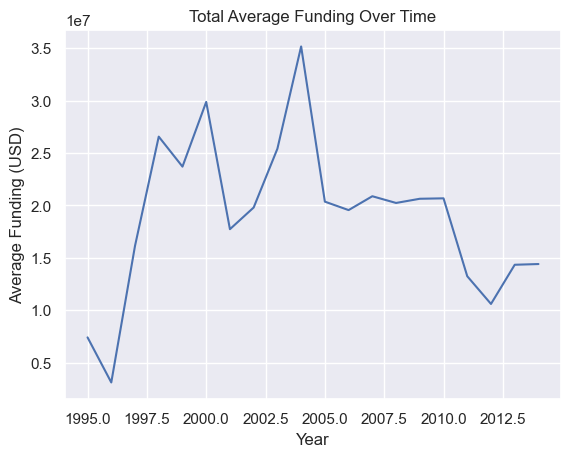

In [111]:
# Group the DataFrame by 'funded_at' and sum the 'funding_total_usd' values
total_funding_by_time = df.drop_duplicates(subset=['permalink']).groupby('funded_year_new')['funding_total_usd'].mean()

# Plot the sum of funding values against time
total_funding_by_time.plot()
plt.xlabel('Year')
plt.ylabel('Average Funding (USD)')
plt.title('Total Average Funding Over Time')
plt.show()

The funding landscape has seen major changes over the years. A significant surge occurred in 1996, fueled by strong economic development. This trend can be attributed to by factors such as technological advancements, globalization,..etc. However, the collapse of the dot-com boom in 2001 resulted in a significant reduction in funding levels. The succeeding three years saw a strong comeback, peaking in 2004. It can be thought of as a governmental effort to regulate the recession in 2001. Nonetheless, a declining trend started, exacerbated by the fallout from the 2008 global financial crisis. By 2011, funding had fallen to its lowest level since 1996, reflecting the persistent economic struggles and financial uncertainties.

It is also interesting to see which quarter on average receive the most fundings over time. Hence, I am creating a histogram distribution of average funding per quarter from 1995 to 2015. As can be seen, the amount of fundings received does not differ much across quarters. 

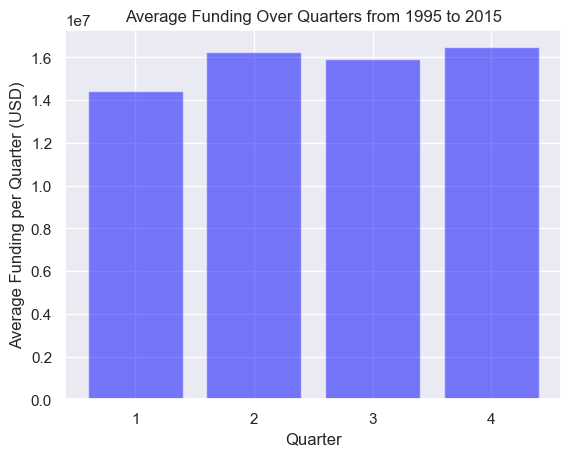

In [112]:
# Create quarter column
df['funded_at'] = pd.to_datetime(df['funded_at'])
df['funded_quarter'] = df['funded_at'].dt.quarter

# Group the DataFrame by 'funded_quarter' and calculate the mean of 'funding_total_usd'
total_funding_by_quarter = df.drop_duplicates(subset=['permalink']).groupby('funded_quarter')['funding_total_usd'].mean()

# Create a histogram with quarters on the x-axis and mean funding on the y-axis
plt.bar(total_funding_by_quarter.index, total_funding_by_quarter.values, align='center', alpha=0.5, color='blue')
plt.xlabel('Quarter')
plt.ylabel('Average Funding per Quarter (USD)')
plt.title('Average Funding Over Quarters from 1995 to 2015')
plt.xticks([1, 2, 3, 4])  # Set the ticks for quarters
plt.grid(True)  # Add grid lines for better readability
plt.show()

## Total funding overtime broken down to top 5 highest funded countries

Moving on to country level, we now identify which 5 countries receive the most fundings across the 20 years period. 

In [115]:
# Group the DataFrame by 'country_code' and sum the 'funding_total_usd' values, then sort the total funding values 
# and select the top 5 countries
top_countries = df.drop_duplicates(subset=['permalink']).groupby('country_code')['funding_total_usd'].sum().nlargest(5).index
print('Top 5 highest funded countries:', top_countries.tolist())

Top 5 highest funded countries: ['USA', 'CHN', 'GBR', 'IND', 'CAN']


The 5 countries are: The USA, China, United Kingdom (Great Britain), India and Canada  

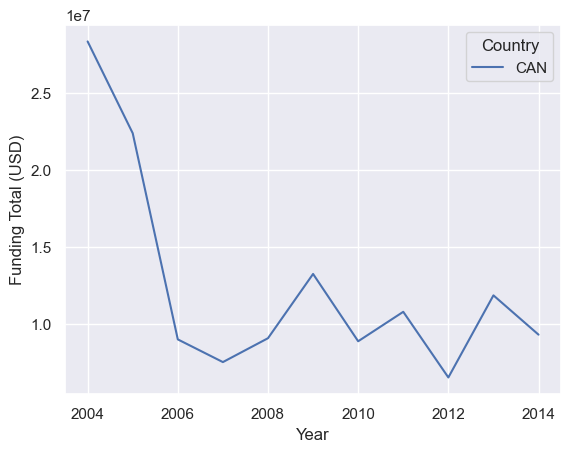

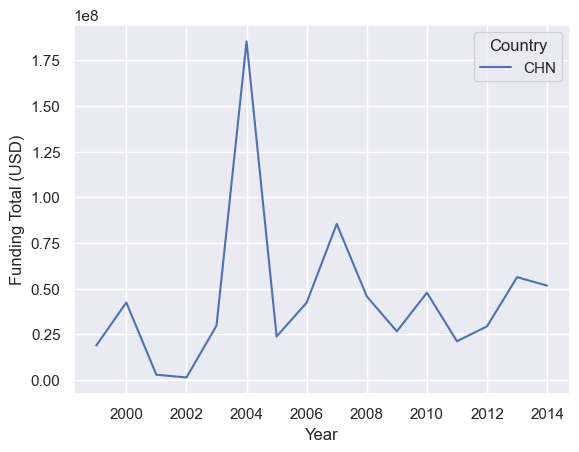

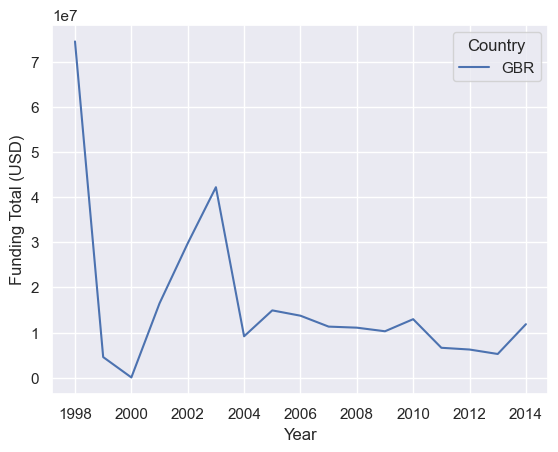

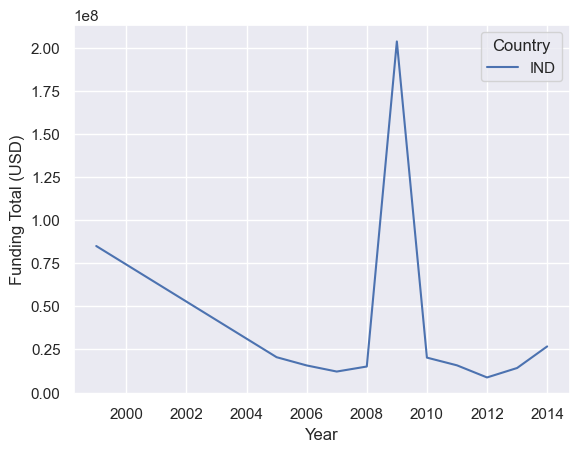

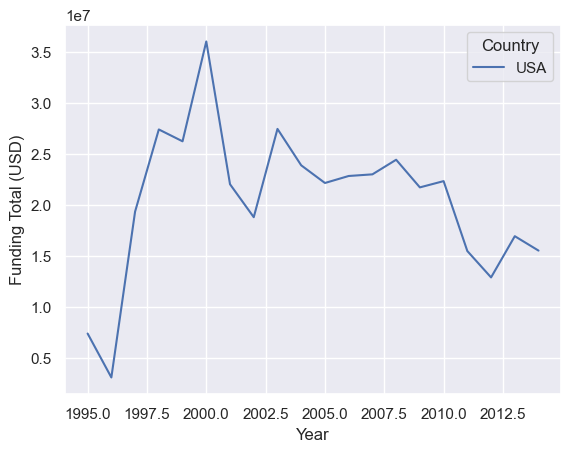

In [116]:
# Filter the DataFrame for the top 5 countries
top_countries_funding = df[df['country_code'].isin(top_countries)].drop_duplicates(subset=['permalink'])

grouped_by_year = top_countries_funding.groupby(['country_code', 'funded_year_new'])['funding_total_usd'].mean().reset_index()

# Plot the funding over time for the top 5 countries
for country, group in grouped_by_year.groupby('country_code'):
    group.plot(x='funded_year_new', y='funding_total_usd', label=country)
    plt.xlabel('Year')
    plt.ylabel('Funding Total (USD)')
    plt.legend(title='Country')

plt.show()


From 2004 to 2006, Canada's received funding fell significantly, that said, it maintains relative stability in subsequent years. In contrast, China experienced a spike during the same era, particularly in 2004-2005, followed by a plateau of roughly 0.75 USD units. Similarly, China and India experienced peaks in specific times before maintaining rather stable received funding levels. In comparison, the United States had a more constant rising trend in funding, with no large surges at any given time.

Then, we create a pie chart to gain insights into how the fundings each contries received look like, relative to each other

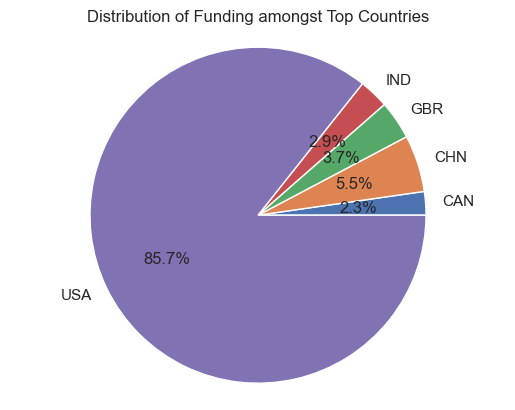

In [117]:
# Group the DataFrame by 'country_code' and sum the 'funding_total_usd' values
total_funding_by_country = top_countries_funding.drop_duplicates(subset=['permalink']).groupby('country_code')['funding_total_usd'].sum()

plt.pie(total_funding_by_country, labels=total_funding_by_country.index, autopct='%1.1f%%')
plt.title('Distribution of Funding amongst Top Countries')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


# Top 5 most funded countries in 1995, 2004 and 2014

Now that we have looked at the distribution of fundings for countries over the 20 years period, let's investigate how this distribution evolve over time. We can do this by creating pie charts for different periods. Here, more specifically, we chose 1995, 2004 and 2014 as the 3 main touch points

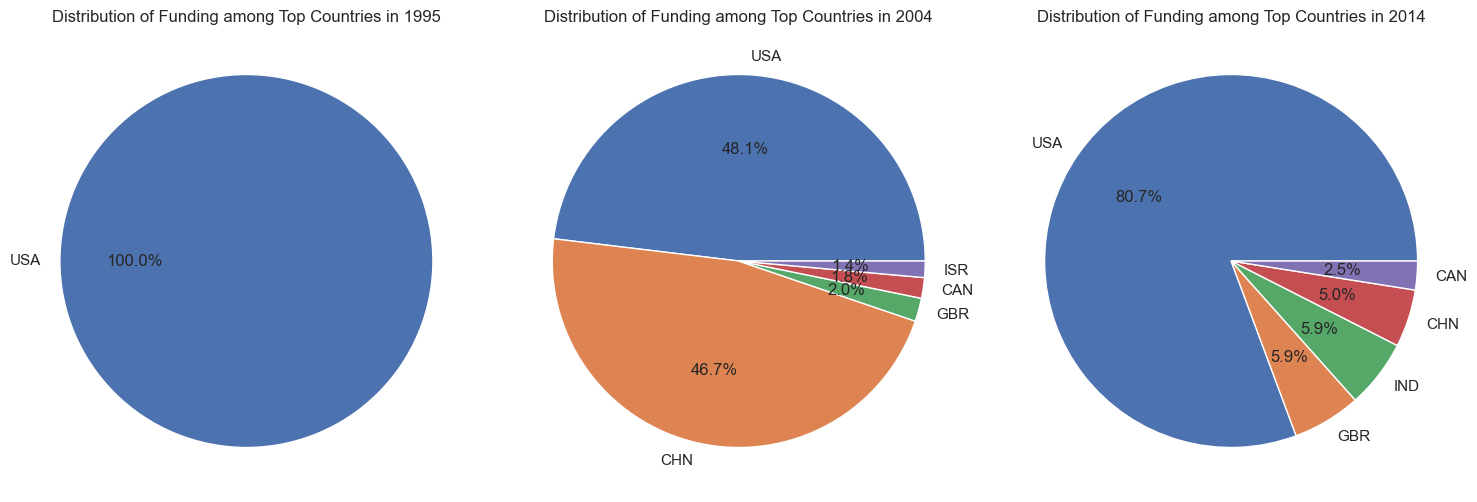

In [118]:
# Filter the DataFrame for the desired years
funding_1995 = df[df['funded_year_new'] == 1995].drop_duplicates(subset=['permalink'])
funding_2004 = df[df['funded_year_new'] == 2004].drop_duplicates(subset=['permalink'])
funding_2014 = df[df['funded_year_new'] == 2014].drop_duplicates(subset=['permalink'])

# Group the filtered DataFrames by 'country_code' and sum the 'funding_total_usd' values
total_funding_1995 = funding_1995.groupby('country_code')['funding_total_usd'].sum().nlargest(5)
total_funding_2004 = funding_2004.groupby('country_code')['funding_total_usd'].sum().nlargest(5)
total_funding_2014 = funding_2014.groupby('country_code')['funding_total_usd'].sum().nlargest(5)

# Plot pie charts for the total funding distribution among the top countries for each year
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Pie chart for 1995
axs[0].pie(total_funding_1995, labels=total_funding_1995.index, autopct='%1.1f%%')
axs[0].set_title('Distribution of Funding among Top Countries in 1995')

# Pie chart for 2004
axs[1].pie(total_funding_2004, labels=total_funding_2004.index, autopct='%1.1f%%')
axs[1].set_title('Distribution of Funding among Top Countries in 2004')

# Pie chart for 2014
axs[2].pie(total_funding_2014, labels=total_funding_2014.index, autopct='%1.1f%%')
axs[2].set_title('Distribution of Funding among Top Countries in 2014')



# Ensure equal aspect ratio for both pie charts
for ax in axs:
    ax.axis('equal')

In 1995, the United States was the sole recipient of funding, enjoying a monopoly in the market. However, by 2004, the distribution of funding between the USA and China became roughly equal, with the USA slightly ahead. Together, these two markets accounted for approximately 94.8% of the total market share. The remaining portion was shared among Canada, Israel, and the UK. By 2015, the USA regained its dominance, capturing more than 80% of the market share. The UK, India, China, and Canada followed in terms of market share. Notably, these five countries consistently ranked among the top five most funded countries over the 20-year period.

# Investor raised amount distribution

After looking at which countries received the most fundings, we turn to the ones that invest the most

In [119]:
# Group the DataFrame by 'investor_country_code' and sum the 'funding_total_usd' values, then sort the total funding values 
# and select the top 5 countries
top_countries = df.groupby('investor_country_code')['raised_amount_usd'].sum().nlargest(5).index
# print('Top 5 most funded countries:', top_countries.tolist())

# Filter the DataFrame for the top 5 countries
top_countries_investors = df[df['investor_country_code'].isin(top_countries)]

grouped_by_year = top_countries_investors.groupby(['investor_country_code', 'funded_year_new'])['raised_amount_usd'].mean().reset_index()

top_countries 

Index(['USA', 'GBR', 'CHN', 'FRA', 'CAN'], dtype='object', name='investor_country_code')

From the output, it is known that USA, the UK, China, Canada and France are the top 5 countries that do most investing. We then plot these investments across time, from 1995 to 2015

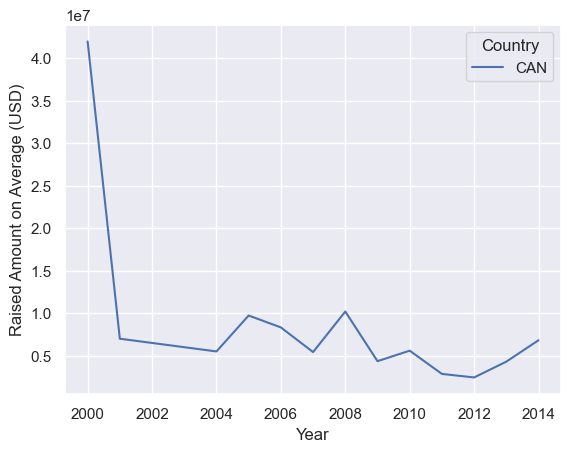

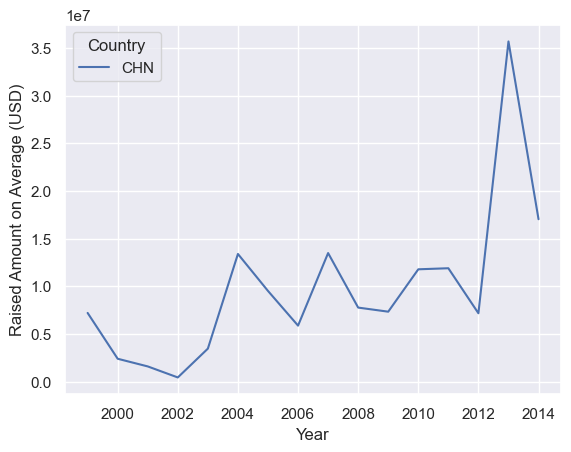

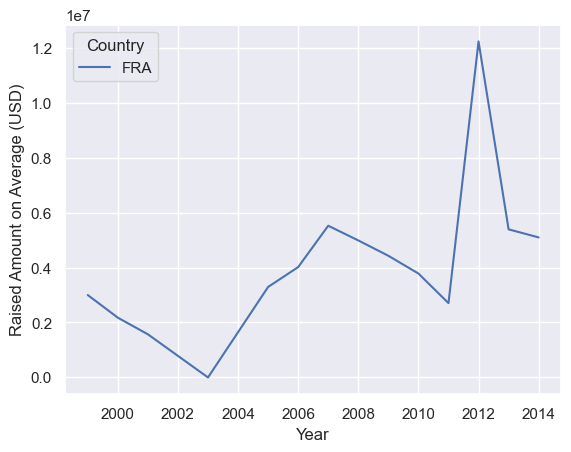

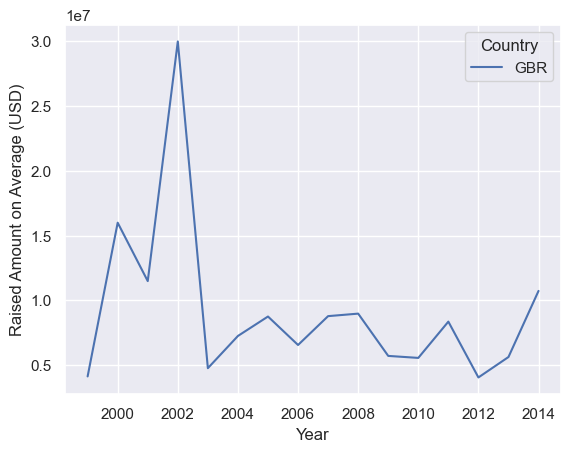

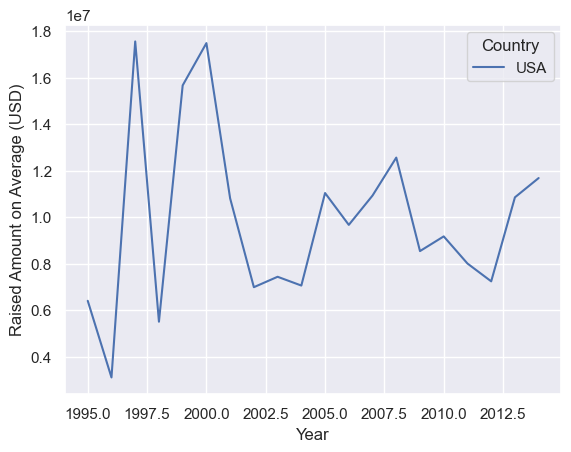

In [120]:
# Plot the funding over time for the top 5 countries
for country, group in grouped_by_year.groupby('investor_country_code'):
    group.plot(x='funded_year_new', y='raised_amount_usd', label=country)
    plt.xlabel('Year')
    plt.ylabel('Raised Amount on Average (USD)')
    plt.legend(title='Country')

plt.show()

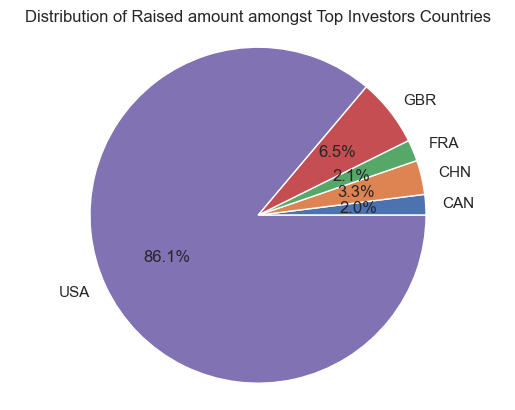

In [121]:
# Group the DataFrame by 'country_code' and sum the 'funding_total_usd' values
total_raised_by_investor_country = top_countries_investors.groupby('investor_country_code')['raised_amount_usd'].sum()

plt.pie(total_raised_by_investor_country, labels=total_raised_by_investor_country.index, autopct='%1.1f%%')
plt.title('Distribution of Raised amount amongst Top Investors Countries')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

Similar to funding, the USA also ranked first in terms of investing, accouting for 86.1% of investments. Followed by is the other said countries, with a total portion of 13.9%

# Economic factors

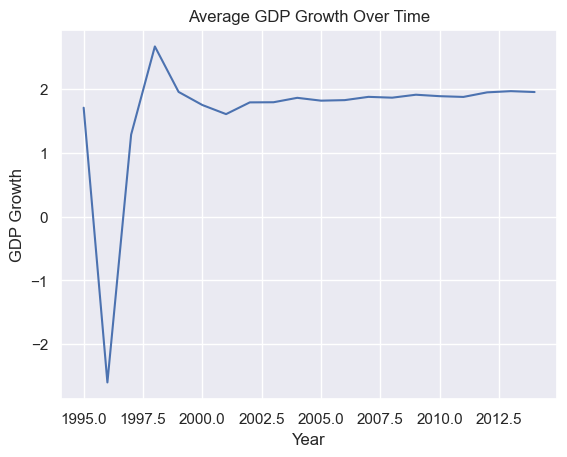

In [122]:
# Group the DataFrame by 'funded_at' and sum the 'gdp_capita' values
total_funding_by_time = df.drop_duplicates(subset=['permalink']).groupby('funded_year_new')['gdp_growth'].mean()

# Plot the sum of funding values
total_funding_by_time.plot()
plt.xlabel('Year')
plt.ylabel('GDP Growth')
plt.title('Average GDP Growth Over Time')
plt.show()

Above is line graph depicting global average GDP growth from 1995-2015, with a notable dip around 1996. This dip suggests a period of economic slowdown or contraction, potentially influenced by various factors such as economic recessions, geopolitical events and such. For instance, the Asian financial crisis happened around that time. 

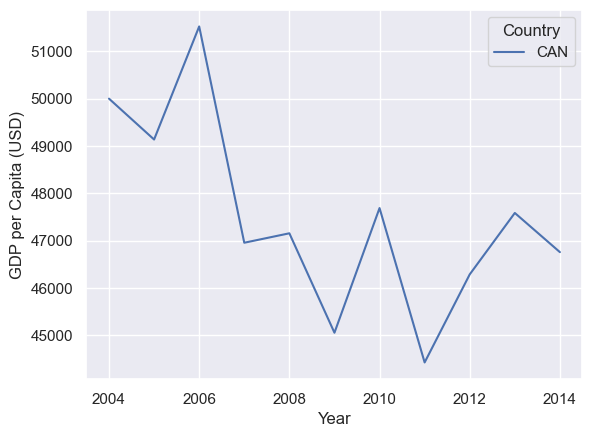

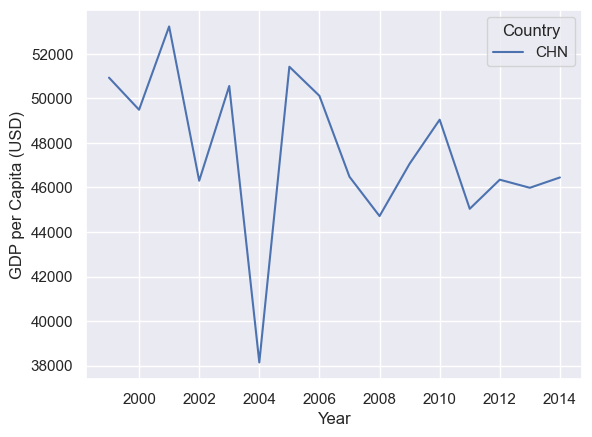

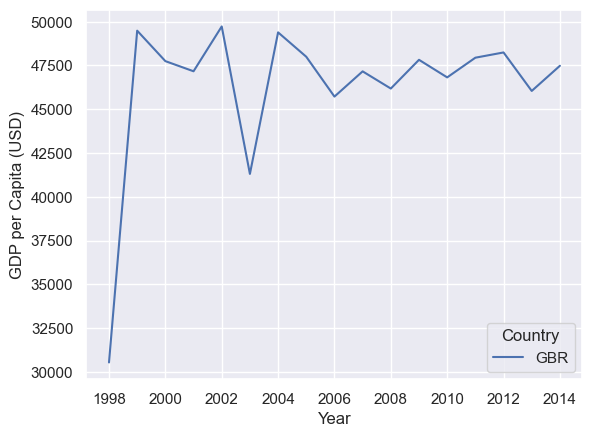

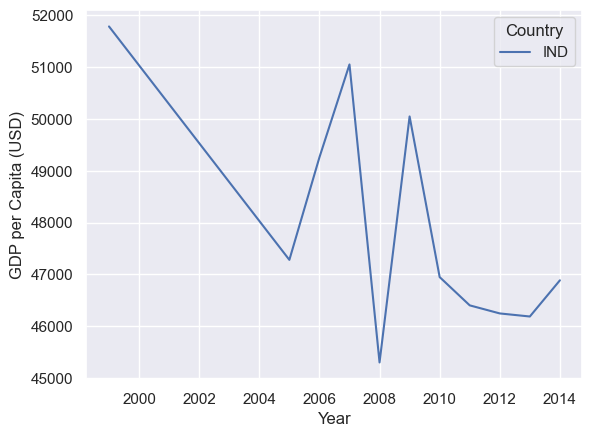

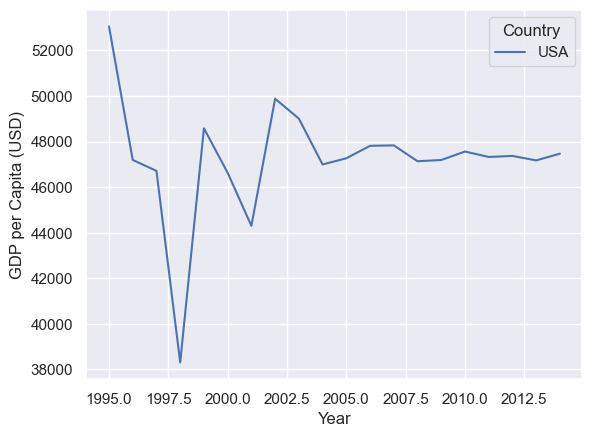

In [123]:
grouped_by_year = top_countries_funding.groupby(['country_code', 'funded_year_new'])['gdp_capita'].mean().reset_index()

# Plot the GDP per capita over time for the top 5 countries
for country, group in grouped_by_year.groupby('country_code'):
    group.plot(x='funded_year_new', y='gdp_capita', label=country)
    plt.xlabel('Year')
    plt.ylabel('GDP per Capita (USD)')
    plt.legend(title='Country')

plt.show()

Next we plot the average GDP per capita per country. While on individual level, the countries experience dips or upticks at different instances in time. For example, the sudden decline in average GDP per capita in India could be correlated with the global financial crisis happening at that time. Other fluctuations in the variable, such as for Great Britain in 2004, could be attributed to volatile economic state and exchange rate instability at the time.

We then evaluate the evoluation of female participation overtime, first on a global level. While there has been a significant decrease from 1996 - 1997, the amount of female who participate in various aspects of economic and social activities quickly recover and stays relatively stable from 2000 onwards

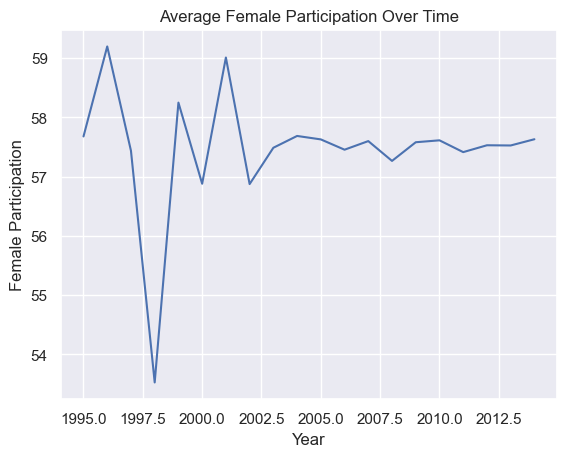

In [124]:
# Group the DataFrame by 'funded_at' and sum the 'female_participation' values
total_funding_by_time = df.drop_duplicates(subset=['permalink']).groupby('funded_year_new')['female_participation'].mean()

# Plot the sum of funding values against time
total_funding_by_time.plot()
plt.xlabel('Year')
plt.ylabel('Female Participation')
plt.title('Average Female Participation Over Time')
plt.show()

In Canada, female participation in economic activities experienced a significant increase in 2005, maintaining stability thereafter. Conversely, in China, there was a decrease in female participation from 2005, failing to recover to pre-2004 levels. For Britain, although there was a decrease in average female participation in 2003, it quickly rebounded and remained stable thereafter. In India, female involvement in economic activities showed intermittent distribution across the 20-year period without following a specific trend. In the USA, similar to Britain, there was a sharp decrease in mid-1997, but this scenario was short-lived as female participation quickly recovered and remained relatively stable thereafter. These trends highlight the diverse patterns of female participation in economic activities among the top five countries that received the most funding.

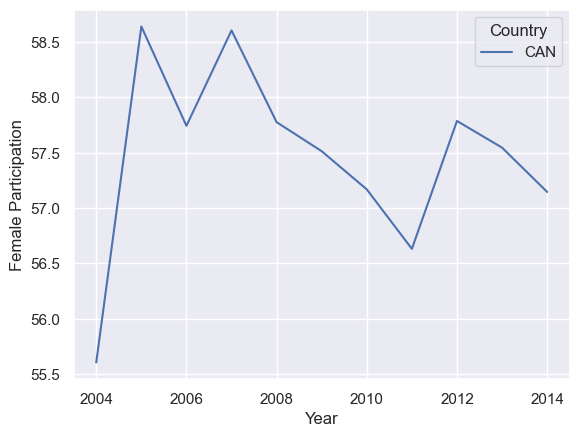

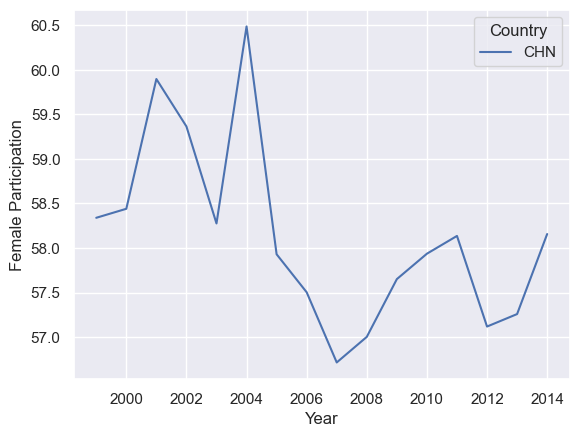

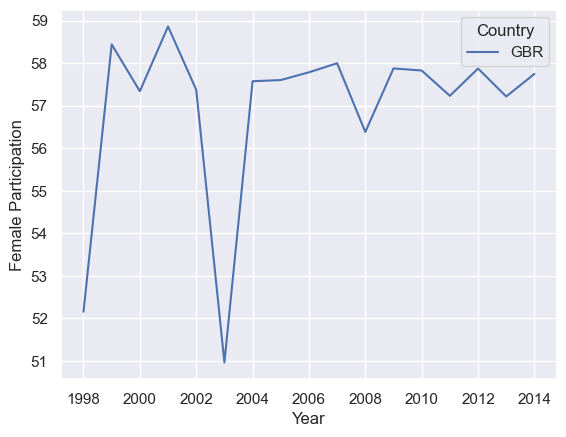

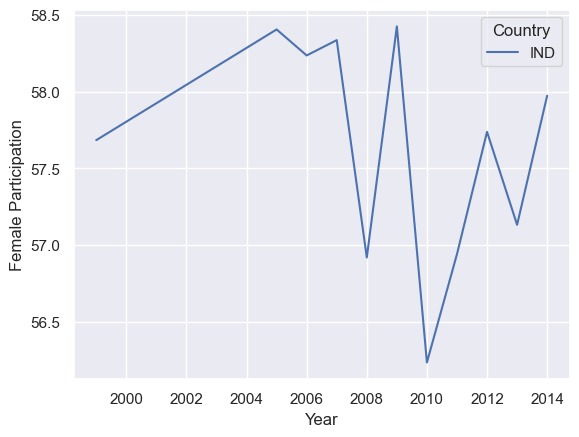

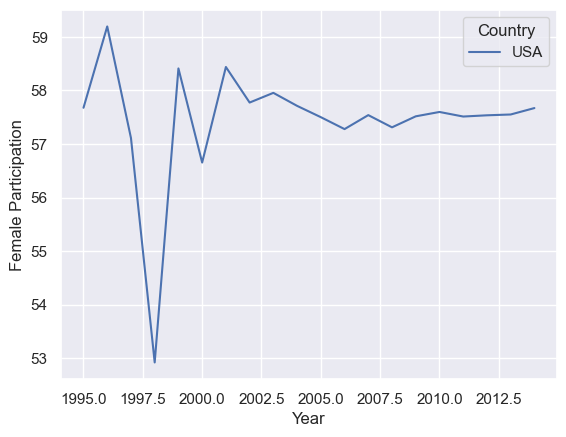

In [125]:
grouped_by_year = top_countries_funding.groupby(['country_code', 'funded_year_new'])['female_participation'].mean().reset_index()

# Plot the GDP per capita over time for the top 5 countries
for country, group in grouped_by_year.groupby('country_code'):
    group.plot(x='funded_year_new', y='female_participation', label=country)
    plt.xlabel('Year')
    plt.ylabel('Female Participation')
    plt.legend(title='Country')

plt.show()

Average interest rate spiked and stay from 1996 to 1999, at the most of 6%. This interest rate, however, has dropped since 2000 and stays relatively stable since, with a minor spike during 2000-2002. Note that this is an average, global interest rate.

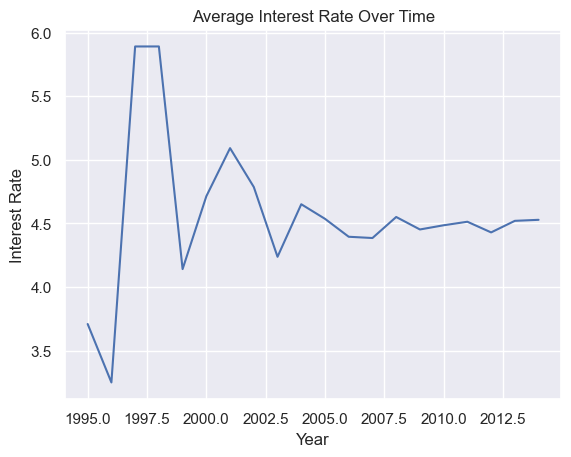

In [126]:
# Group the DataFrame by 'funded_at' and sum the 'interest_rate' values
total_funding_by_time = df.drop_duplicates(subset=['permalink']).groupby('funded_year_new')['interest_rate'].mean()

# Plot the sum of funding values against time
total_funding_by_time.plot()
plt.xlabel('Year')
plt.ylabel('Interest Rate')
plt.title('Average Interest Rate Over Time')
plt.show()

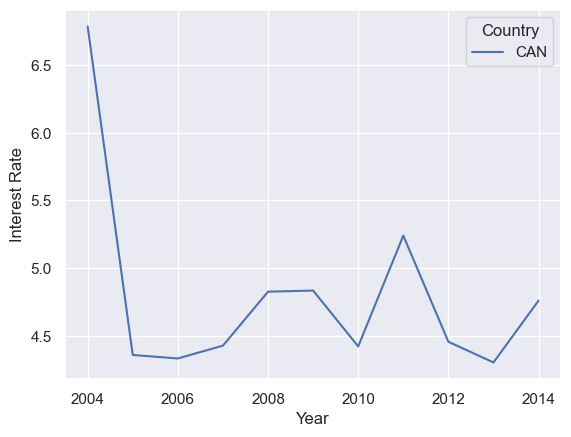

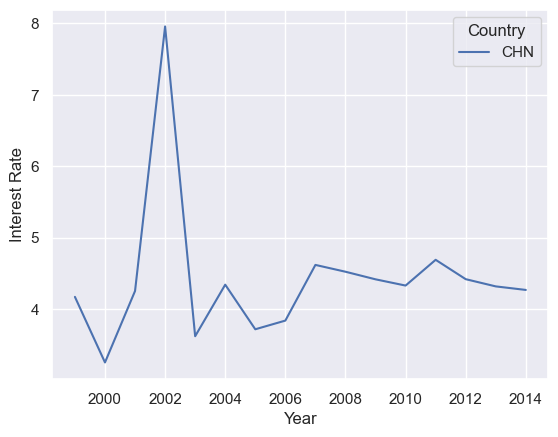

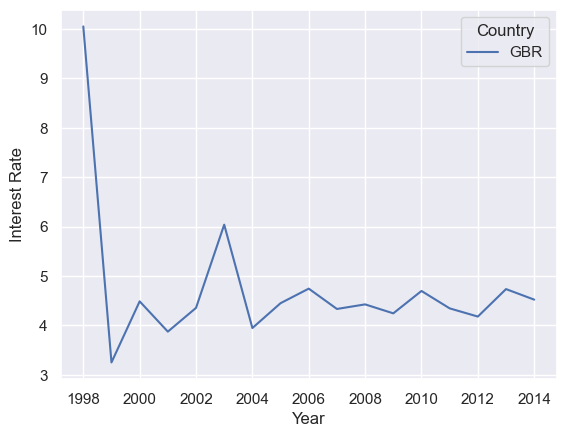

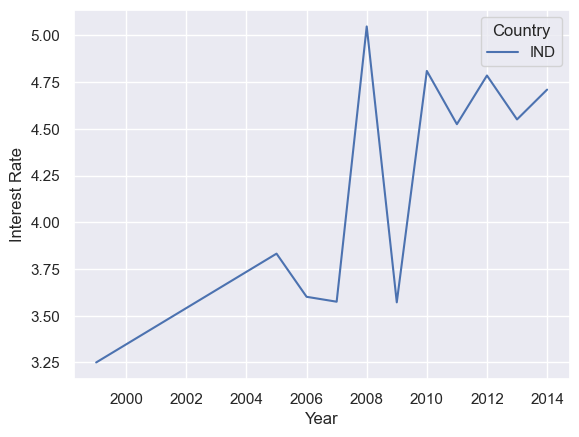

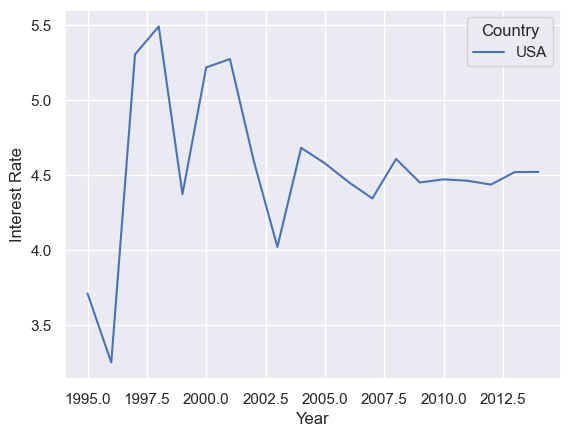

In [127]:
grouped_by_year = top_countries_funding.groupby(['country_code', 'funded_year_new'])['interest_rate'].mean().reset_index()

# Plot the GDP per capita over time for the top 5 countries
for country, group in grouped_by_year.groupby('country_code'):
    group.plot(x='funded_year_new', y='interest_rate', label=country)
    plt.xlabel('Year')
    plt.ylabel('Interest Rate')
    plt.legend(title='Country')

plt.show()

Again, we look at interest rate development for specific top 5 most funded countries

# Markets and rounds

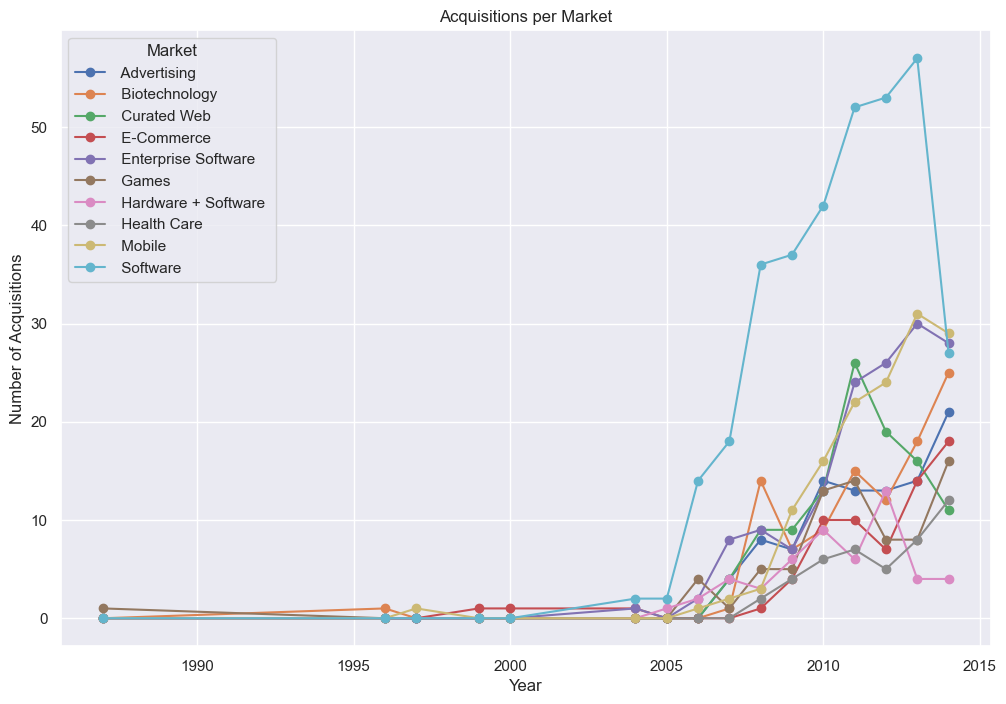

In [128]:
import matplotlib.pyplot as plt

##filter on years 1995 to 2015??
top_10_markets = df['market'].value_counts().nlargest(10).index.tolist()
markets_top_10 = df[df['market'].isin(top_10_markets)].drop_duplicates(subset = "permalink")

# Group by 'acquired_year_new' and 'market', and count the number of acquisitions
markets_top_10_over_time = markets_top_10.groupby(['acquired_year_new', 'market']).size().unstack(fill_value=0)

# Plot the trends for each market
ax = markets_top_10_over_time.plot(kind='line', figsize=(12, 8), marker='o')
plt.title('Acquisitions per Market')
plt.xlabel('Year')
plt.ylabel('Number of Acquisitions')
plt.legend(title='Market')
plt.grid(True)

#years = range(int(min(markets_top_10_over_time.index)), int(max(markets_top_10_over_time)) + 1)
#ax.set_xticks(years)

plt.show()

The figure above illustrates the acquisition trends across different markets. Each market's acquisition count is tallied over the entire dataset period. A notable increase in acquisitions within a particular market suggests heightened interest from larger companies seeking to enter that market, which could be motivated by new opportunities and access to a broader customer base. Thus, a surge in acquisitions could mean that the market is relatively attractive to potential buyers and investors. 

This insight aligns with the top markets depicted in the graph, which were experiencing a significant boom around that time. For instance, the software market witnessed a substantial surge in acquisitions after 2004, which indicates its attractiveness towards buying corporations. (Empirical evidence supports this, with reports showing a substantial increase in mergers and acquisitions within the software industry during this period. Companies like Google, Microsoft, and Oracle notably expanded their portfolios through strategic acquisitions, consolidating their positions in the software market and capitalizing on emerging opportunities.)

In [129]:
top_markets = df.drop_duplicates(subset="permalink").groupby('market')['funding_total_usd'].sum().nlargest(5).index
print('Top 5 markets with highest funding:', top_markets.tolist())


Top 5 markets with highest funding: [' Biotechnology ', ' Software ', ' Clean Technology ', ' Health Care ', ' E-Commerce ']


The top five markets that have received the highest funding over time are: Biotechnology, Software, Clean Technology, Health Care, and E-Commerce. We intentionally chose to focus on markets with the largest cumulative funding instead of relying on average funding over time, as this approach accurately identifies the market giants by highlighting the magnitude of investment in that market across the decades present in the dataset. 

In [130]:
# Filter DataFrame to include only entries from the top markets
top_markets_df = df[df['market'].isin(top_markets)].drop_duplicates(subset=['permalink'])

# Calculate the average number of fundraising rounds for each market
average_rounds = top_markets_df.groupby('market')['funding_rounds'].mean()

print('Average number of fundraising rounds for the top markets:')
print(average_rounds)


Average number of fundraising rounds for the top markets:
market
 Biotechnology        2.325214
 Clean Technology     2.294498
 E-Commerce           1.923375
 Health Care          2.604194
 Software             1.839005
Name: funding_rounds, dtype: float64


Delving deeper into investment rounds will help us especially when trying to understand the possible variations of the tagret variable, i.e. the overall funding amount a start-up receives. From a logical standpoint, more funding rounds for a start-up could result in higher funding amounts obtained. We first attempt to understand what is the average of funding rounds per markets, specifically the five most funded markets identified previously.

In [131]:
# Filter DataFrame to include only entries from the top markets
top_markets_df = df[df['market'].isin(top_markets)].drop_duplicates(subset=['permalink'])

# Calculate the average number of fundraising rounds for each market
median_rounds = top_markets_df.groupby('market')['funding_rounds'].median()

print('Median number of fundraising rounds for the top markets:')
print(median_rounds)


Median number of fundraising rounds for the top markets:
market
 Biotechnology        2.0
 Clean Technology     2.0
 E-Commerce           1.0
 Health Care          2.0
 Software             1.0
Name: funding_rounds, dtype: float64


However, when we are dealing with a non-normal distribution of data, it is more optimal to use median over mean. Here, we suspect our data distribution to be right-skewed, as most companies will receive 1 funding round only (or close to that number). Among the top five markets, the median number of rounds is 1 or 2, but for less funded markets, we could expect the median number to be 1 in most instances. 

/var/folders/lm/bl1smj695w5cs7_g73j9m6_r0000gn/T/ipykernel_19735/1790263743.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_rounds, x='market', y='funding_rounds', palette='viridis')


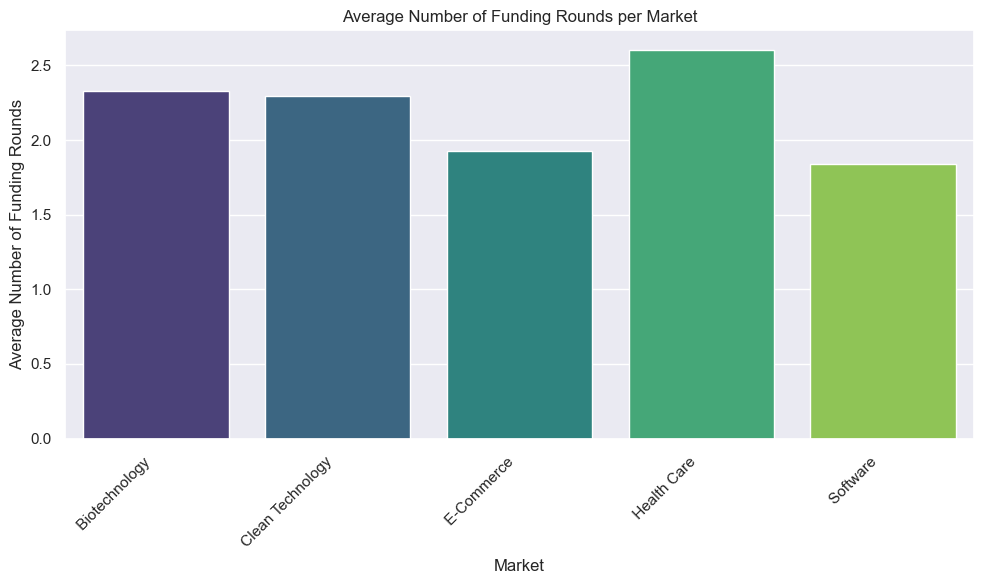

In [132]:
##median??
# Calculate the average number of fundraising rounds for each market
average_rounds = top_markets_df.groupby('market')['funding_rounds'].mean().reset_index()

# Create a bar plot for the average number of fundraising rounds per market
plt.figure(figsize=(10, 6))
sns.barplot(data=average_rounds, x='market', y='funding_rounds', palette='viridis')
plt.title('Average Number of Funding Rounds per Market')
plt.xlabel('Market')
plt.ylabel('Average Number of Funding Rounds')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

/var/folders/lm/bl1smj695w5cs7_g73j9m6_r0000gn/T/ipykernel_19735/3358202379.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_rounds, x='market', y='funding_rounds', palette='viridis')


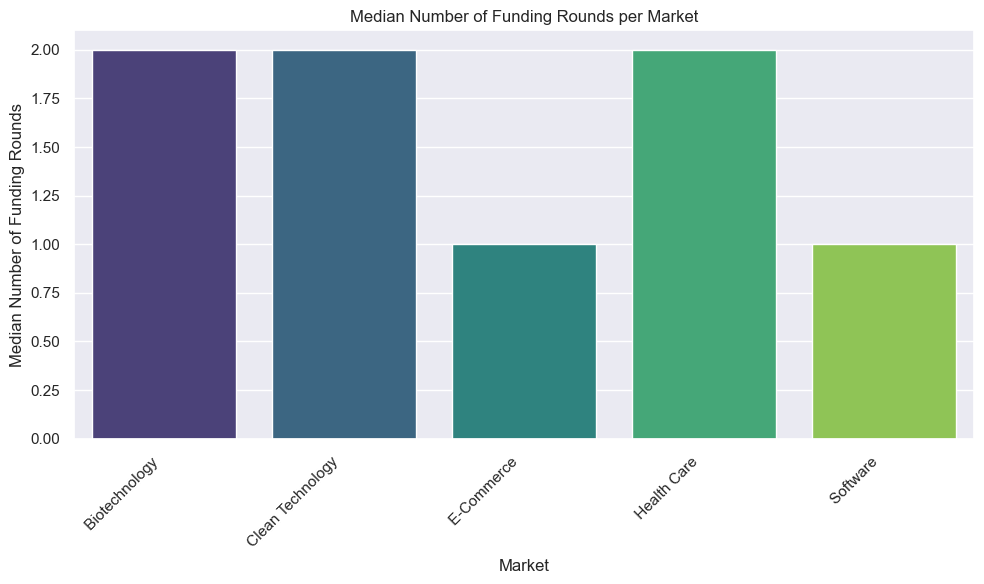

In [133]:

# Calculate the median number of fundraising rounds for each market
average_rounds = top_markets_df.groupby('market')['funding_rounds'].median().reset_index()

# Create a bar plot for the median number of fundraising rounds per market
plt.figure(figsize=(10, 6))
sns.barplot(data=average_rounds, x='market', y='funding_rounds', palette='viridis')
plt.title('Median Number of Funding Rounds per Market')
plt.xlabel('Market')
plt.ylabel('Median Number of Funding Rounds')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

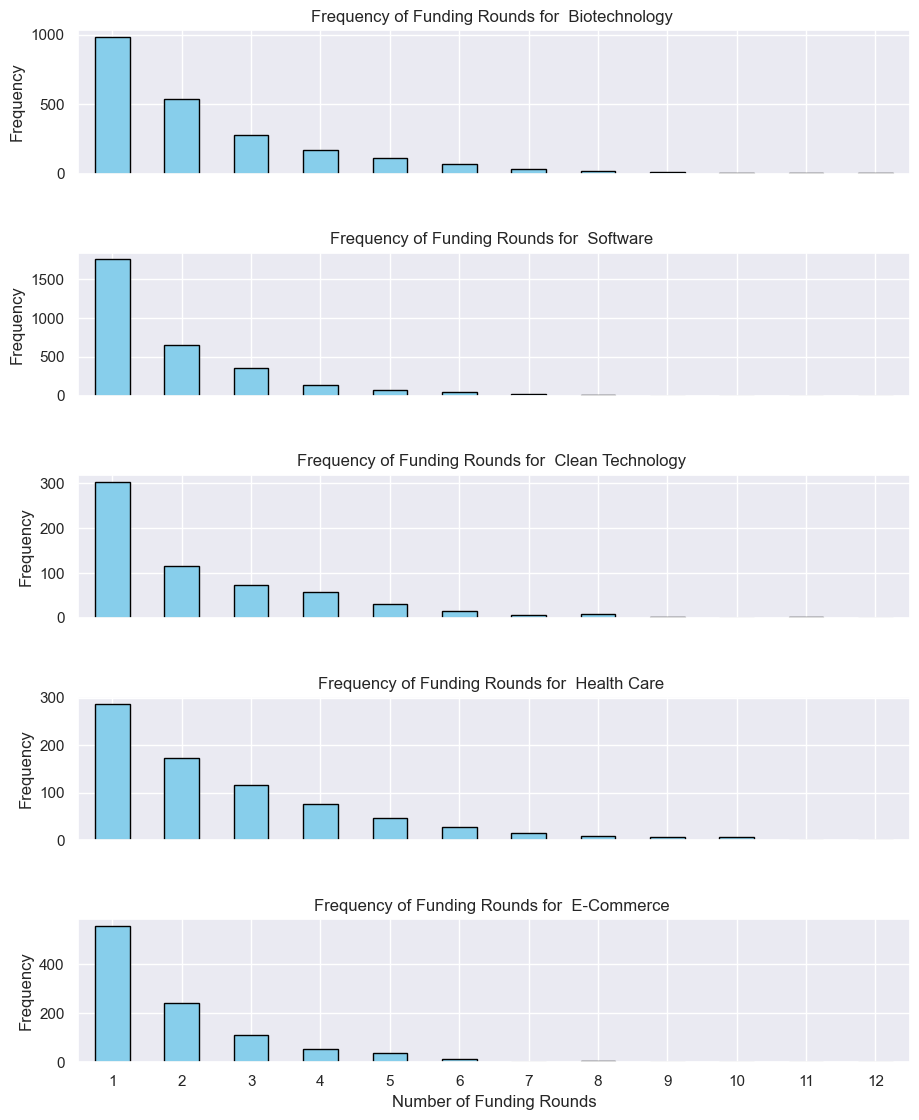

In [134]:
# Create subplots for each market
fig, axes = plt.subplots(nrows=len(top_markets), figsize=(10, 12), sharex=True)

# Loop through each market
for i, market in enumerate(top_markets):
    # Filter DataFrame for the current market
    market_df = top_markets_df[top_markets_df['market'] == market]
    
    # Count the frequency of each number of rounds
    round_counts = market_df['funding_rounds'].value_counts().sort_index()
    
    # Create bar plot for frequency of fundraising rounds
    round_counts.plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f'Frequency of Funding Rounds for {market}')
    axes[i].set_xlabel('Number of Funding Rounds')
    axes[i].set_ylabel('Frequency')
    axes[i].xaxis.set_tick_params(rotation=0)  # Rotate x-axis labels to be horizontal

# Adjust layout and display the plot
plt.tight_layout(pad=3.0)
plt.show()



We verify our theory about the data following a non-normal distribution above, by plotting the frequencies of each amount of funding rounds per market. As evident fom the figures, our expectations were valid, as we experience a right-skewedness that is logical given the variable and its context. 

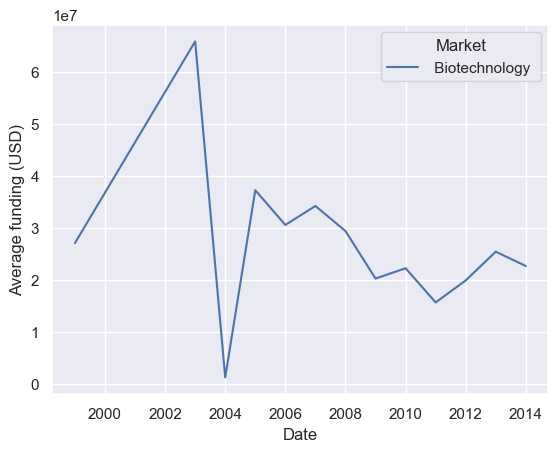

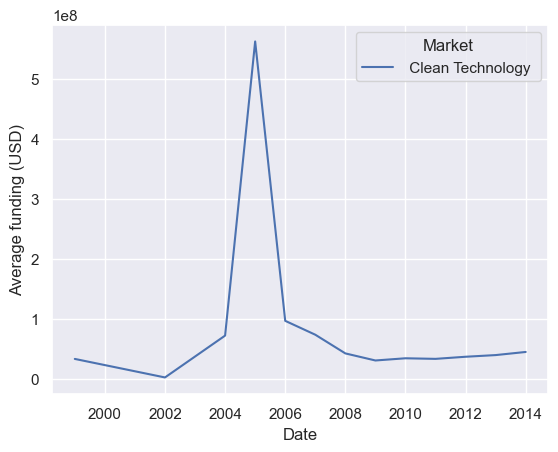

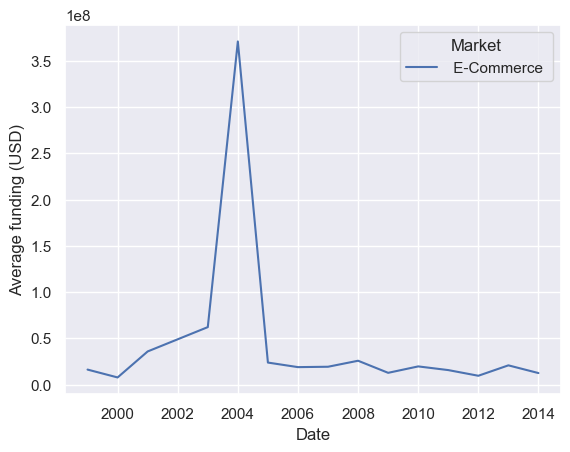

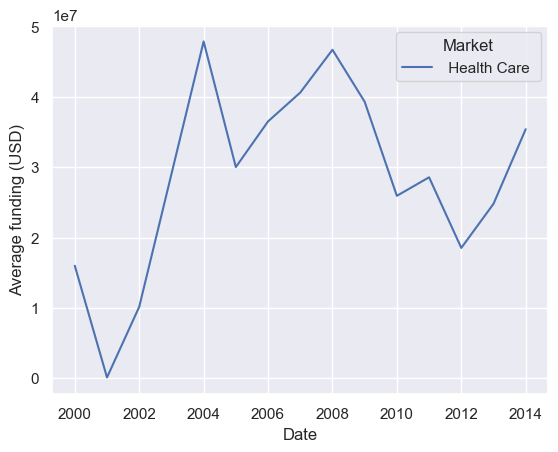

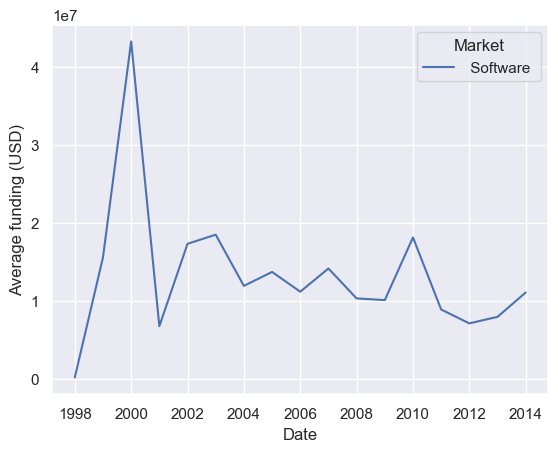

In [135]:
# Filter the DataFrame for the top 5 countries
top_markets_raised = df[df['market'].isin(top_markets)].drop_duplicates(subset= "permalink")
grouped_by_year = top_markets_raised.groupby(['market', 'funded_year_new'])['funding_total_usd'].mean().reset_index()

# Plot the funding over time for the top 5 countries
#for market, group in top_markets_raised.groupby('market'):
 #   group.plot(x='funded_at', y='raised_amount_usd', label=market)
  #  plt.xlabel('Date')
   # plt.ylabel('Funding Total (USD)')
    #plt.legend(title='Market')

#plt.show()

for market, group in grouped_by_year.groupby('market'):
    group.plot(x='funded_year_new', y='funding_total_usd', label=market)
    plt.xlabel('Date')
    plt.ylabel('Average funding (USD)')
    plt.legend(title='Market')

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()

We focus once again on visualizing our target variable to better understand the trends and context within the specified timeframe. The figures above describe the trend in average funding for each market over the dataset time period. 

To understand the graphs better, let us focus on the e-commerce market as an example. The notable uptick in the early 2000´s could be explained by the e-commerce market transitioning from the first wave to second wave, which was mainly marked by the development of web-based technologies. This provides more opportunities to new companies as well as a higher general interest in the market. 

Another interesting insight that we can retain from the graphs is the last graph describing the average funding trend in the software market. We observe an exceptional peak in funding in this market in the late 1990´s, followed by a drastic decline post-2000. This phenomenon can be linked to the dotcom bubble burst. Few years prior to that, many Internet-based start-ups profit off investors providing abundant capital funding due to Internet technology excitement. However, the funding begins to run dry, and plenty of companies were not able to sustain themselves, which eventually caused the 2000 market crash.


# Heatmap

/var/folders/lm/bl1smj695w5cs7_g73j9m6_r0000gn/T/ipykernel_19735/3433928064.py:19: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(small_df.corr())


<Figure size 2000x1000 with 0 Axes>

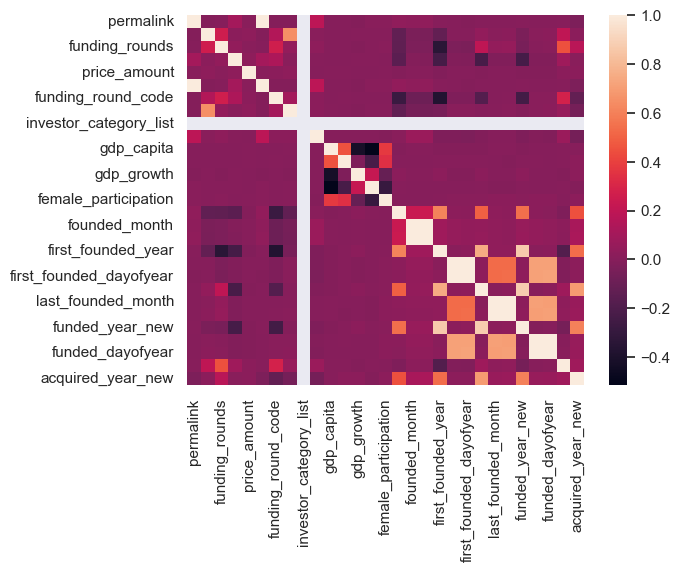

<Figure size 2000x1000 with 0 Axes>

In [136]:
import seaborn as sns

small_df = df[['permalink', 'category_list', 'market', 'funding_total_usd', 'status',
       'country_code', 'state_code', 'region', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'acquirer_permalink',
       'acquirer_category_list', 'acquirer_market', 'acquirer_country_code',
       'acquirer_state_code', 'acquirer_region', 'acquired_at', 'price_amount',
       'funding_round_permalink', 'funding_round_type', 'funding_round_code',
       'funded_at', 'raised_amount_usd', 'investor_category_list',
       'investor_country_code', 'investor_permalink', 'investor_state_code',
       'investor_market', 'investor_region', 'gdp_capita',
       'foreign_direct_investment', 'gdp_growth', 'interest_rate',
       'female_participation', 'founded_year', 'founded_month',
       'founded_dayofyear', 'first_founded_year', 'first_founded_month',
       'first_founded_dayofyear', 'last_founded_year', 'last_founded_month',
       'last_founded_dayofyear', 'funded_year_new', 'funded_month_new',
       'funded_dayofyear', 'investor_count', 'acquired_year_new']]

sns.heatmap(small_df.corr())

plt.figure(figsize=(20, 10))

/var/folders/lm/bl1smj695w5cs7_g73j9m6_r0000gn/T/ipykernel_19735/596521839.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = small_df.corr()[['funding_total_usd']].sort_values(by='funding_total_usd', ascending=False)
/var/folders/lm/bl1smj695w5cs7_g73j9m6_r0000gn/T/ipykernel_19735/596521839.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(small_df.corr()[['funding_total_usd']].sort_values(by='funding_total_usd', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')


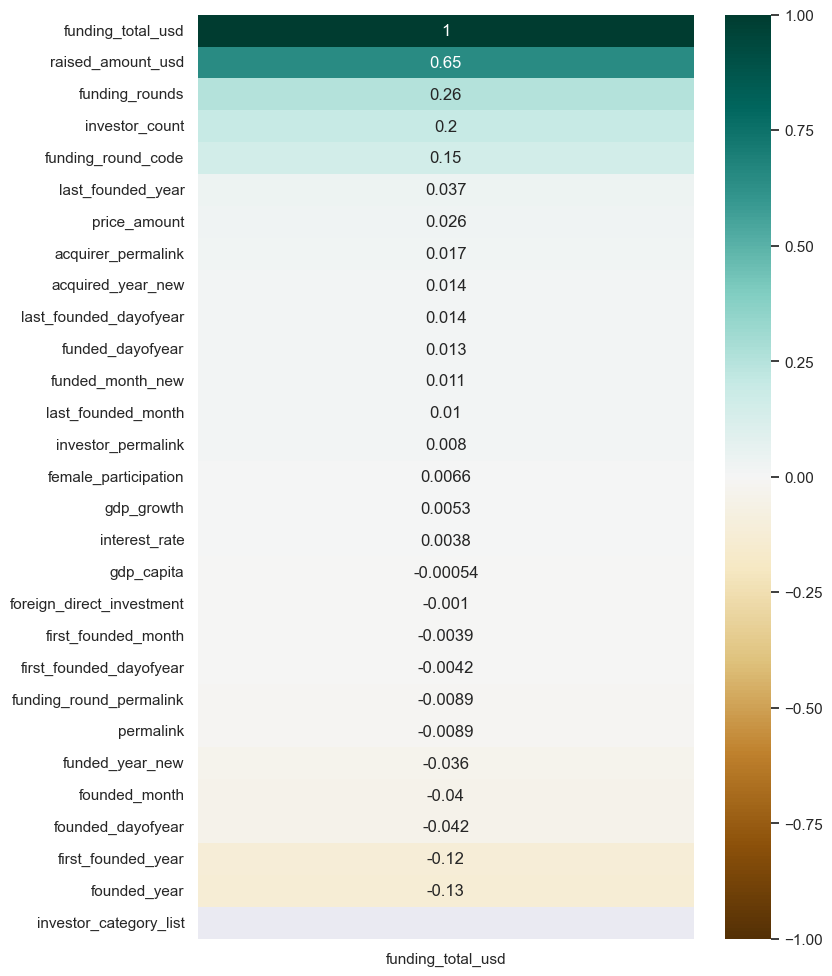

In [137]:
heatmap = small_df.corr()[['funding_total_usd']].sort_values(by='funding_total_usd', ascending=False)

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(small_df.corr()[['funding_total_usd']].sort_values(by='funding_total_usd', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')


Heatmaps are a useful tool for exploring interactions between variables. Here, we present both a classic heatmap illustrating relations between each variable and a heatmap focusing on the correlation between the target variable and the independent variables. From the figure, it's evident that many variables show low correlation with total funding amount (USD). However, a few variables stand out with higher correlation, notably raised amount (in USD), and to some extent, funding rounds and investor count. This finding is particularly valuable for subsequent modeling.

# Pie charts

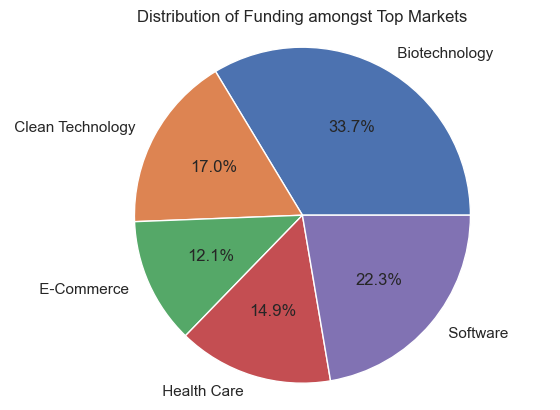

In [138]:
# Group the DataFrame by 'country_code' and sum the 'funding_total_usd' values
total_funding_by_market = top_markets_raised.drop_duplicates(subset=['permalink']).groupby('market')['funding_total_usd'].sum()

plt.pie(total_funding_by_market, labels=total_funding_by_market.index, autopct='%1.1f%%')
plt.title('Distribution of Funding amongst Top Markets')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

We previously identified the top five markets in terms of total funding from 1990 to 2015, and here is the visualization of their respective shares in this group. 

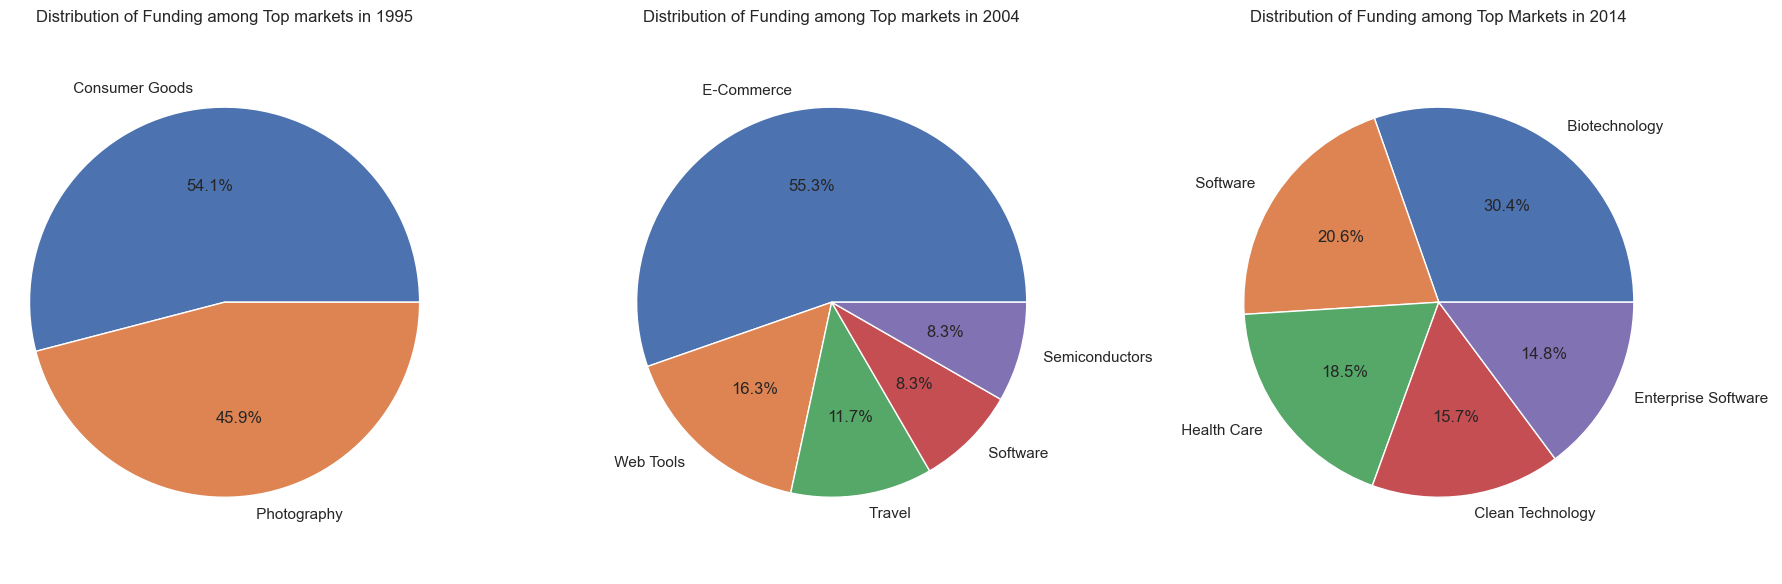

In [139]:
# Filter the DataFrame for the desired years
funding_1995 = df[df['funded_year_new'] == 1995]
funding_2004 = df[df['funded_year_new'] == 2004]
funding_2014 = df[df['funded_year_new'] == 2014]

# Group the filtered DataFrames by 'country_code' and sum the 'funding_total_usd' values
total_funding_1995 = funding_1995.groupby('market')['funding_total_usd'].sum().nlargest(5)
total_funding_2004 = funding_2004.groupby('market')['funding_total_usd'].sum().nlargest(5)
total_funding_2014 = funding_2014.groupby('market')['funding_total_usd'].sum().nlargest(5)

# Plot pie charts for the total funding distribution among the top countries for each year
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Pie chart for 1995
axs[0].pie(total_funding_1995, labels=total_funding_1995.index, autopct='%1.1f%%')
axs[0].set_title('Distribution of Funding among Top markets in 1995')

# Pie chart for 2004
axs[1].pie(total_funding_2004, labels=total_funding_2004.index, autopct='%1.1f%%')
axs[1].set_title('Distribution of Funding among Top markets in 2004')

# Pie chart for 2014
axs[2].pie(total_funding_2014, labels=total_funding_2014.index, autopct='%1.1f%%')
axs[2].set_title('Distribution of Funding among Top Markets in 2014')

# Ensure equal aspect ratio for both pie charts
for ax in axs:
    ax.axis('equal')
    
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

However, we are interested in seeing how the shares evolved over time. For that, we specified three instances throughout the dataset timeframe, and visualized the shares of each of the top markets in terms of total funding. In 1995, consumer goods and photography dominate the funding landscape. Only two markets are shown, this is possibly due lack of data at the earlier periods. In 2004, the top fund-receiving market is by far e-commerce at 55.3% from the top markets shares, followed by web tools, travel, software and semiconductors. Finally, in 2014, the fnding landscape is fairly evenly distributed among biotechnology, software, health care, clean technology and enterprise. 